In [1]:
f = open('data/compare_docs/ground_truth_1.txt')
ground_truth_simple_1 = f.read()
f.close()

f = open('data/compare_docs/ground_truth_2.txt')
ground_truth_simple_2 = f.read()
f.close()




# Rozdział 1: Wstęp i Konfiguracja

Biblioteki, których działanie sprawdzę i porównam to:
PyMuPDF (fitz) – Faworyt w kategorii Zwykły Tekst (szybkość).

pdfplumber – Faworyt w kategorii Tabela (precyzja pozycjonowania).

Marker (lub Docling) – "Czarny koń" oparty na AI, który próbuje robić wszystko naraz (świetny test, czy AI wygrywa z klasycznym kodem).

Praca ma na celu ukazać najprostsze i najszybsze uzycie tych bibliotek i ukazanie, ktora najlepiej poradzila sobie bez tunningu. Oczywistym jest, ze jesli dodatkowo w jakis sposob oczyscimy tekst za pomoca funkcji w pythonie, otrzymalibysmy znacznie lepsze wyniki (szczegolnie dla tych prostszych bibliotek). Lecz to wymagałoby dodatkowycy nakladow pracy, ktora bylaby wymagana dla kazdego nowego typu dokumentu. Jesli w firmie takie dokumenty maja przewaznie taki sam format, zadanie moze miec wiekszy sens. Lecz ja skupilem sie na pokazaniu jak bibioteki radza sobie po prostu po uruchomieniu ich na roznych typach pdf.

Pierwszą kategorią w której zbadam pdf są proste pdf z ksiązek. Posiadaja one strukture wbudowana w pdf, wiec zadanie nie powinno sprawiac trudnosci dla bibliotek. Wynik badam za pomoca funkcji fuzz.ratio ktora bada podobienstwo uzytych slow. Test odbędzie się na dwóch plikach pdf z 3 stronami. Jeden PDF to ksiązka angielska, gdzie struktura kazdej strony jest troche inna - na jednej jest obrazek, na innej wykres i rozne wciecia itp. Drugi pdf jest po polsku i rowniez zawiera 3 strony z roznym formatem. Test ten ma zamiar sprawdzić, czy biblioteki radzą sobie ze zwykłym tekstem z pdf.

Pliki Ground Truth:

De-hyphenation (Łączenie wyrazów): Usunąłem podziały słów na końcu linii (np. "transpor-towa" zmieniłem na "transportowa"). To jest format, którego oczekujemy od dobrego algorytmu.

Paragraph Restoration: Połączyłem rozerwane linie w pełne akapity.

Chart Noise Removal (Odszumianie): Usunąłem "śmieci" z wykresów kołowych (luźne procenty i legendy w środku tekstu), zostawiając tylko podpisy pod wykresami. To kluczowe, bo biblioteki "głupie" (jak surowy PyMuPDF) wrzucą te procenty w środek zdania, a biblioteki "mądre" (Docling/Azure) powinny je ominąć lub sformatować.

Footnotes (Przypisy): Zostawiłem je na dole stron, oddzielone linią, ponieważ są częścią treści, ale nie powinny przerywać głównego wątku.

Strategia przygotowania wzorca (Ground Truth):

Noise Removal (Odszumianie): Całkowicie usunąłem dane liczbowe z osi wykresów (strona 2), które "zaśmiecają" tekst (np. "20000 40000 Balance 1000").

Equation Normalization (Wzory): Wzory matematyczne zapisałem w formie uproszczonej, czytelnej dla człowieka (np. Y = 1 if stroke), ponieważ większość bibliotek PDF (poza specjalistycznymi jak Mathpix) nie wyciągnie czystego LaTeXa, tylko "spłaszczony" tekst.

De-hyphenation: Naprawiłem słowa przecięte myślnikiem (np. "relation-ship" -> "relationship").

OCR Correction: W surowym tekście pojawiły się błędy OCR (np. "epi1eptic se1zure"). Wzorzec zawiera poprawne słowa ("epileptic seizure"), bo do tego dążymy.

# Rozdział 2: Ekstrakcja tekstu ciągłego (E-book/Raport)

In [2]:
from rapidfuzz import fuzz
import time
import fitz  # PyMuPDF
import pdfplumber
import time
from rapidfuzz import fuzz
import docling
from docling.document_converter import DocumentConverter
import pandas as pd
import os
import pandas as pd
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence.models import AnalyzeResult
import re
from dotenv import load_dotenv

# 1. Wczytaj zmienne z pliku .env do środowiska
load_dotenv()

# 2. Pobierz bezpiecznie klucze
AZURE_ENDPOINT = os.getenv("AZURE_ENDPOINT")
AZURE_KEY = os.getenv("AZURE_KEY")

Wpierw zobaczmy jak trzy biblioteki poradzą sobie na ekstrakcji danych ze strony z angielskiej ksiązki. Ponizej przedstawiam jak wyglada strona (pdf):


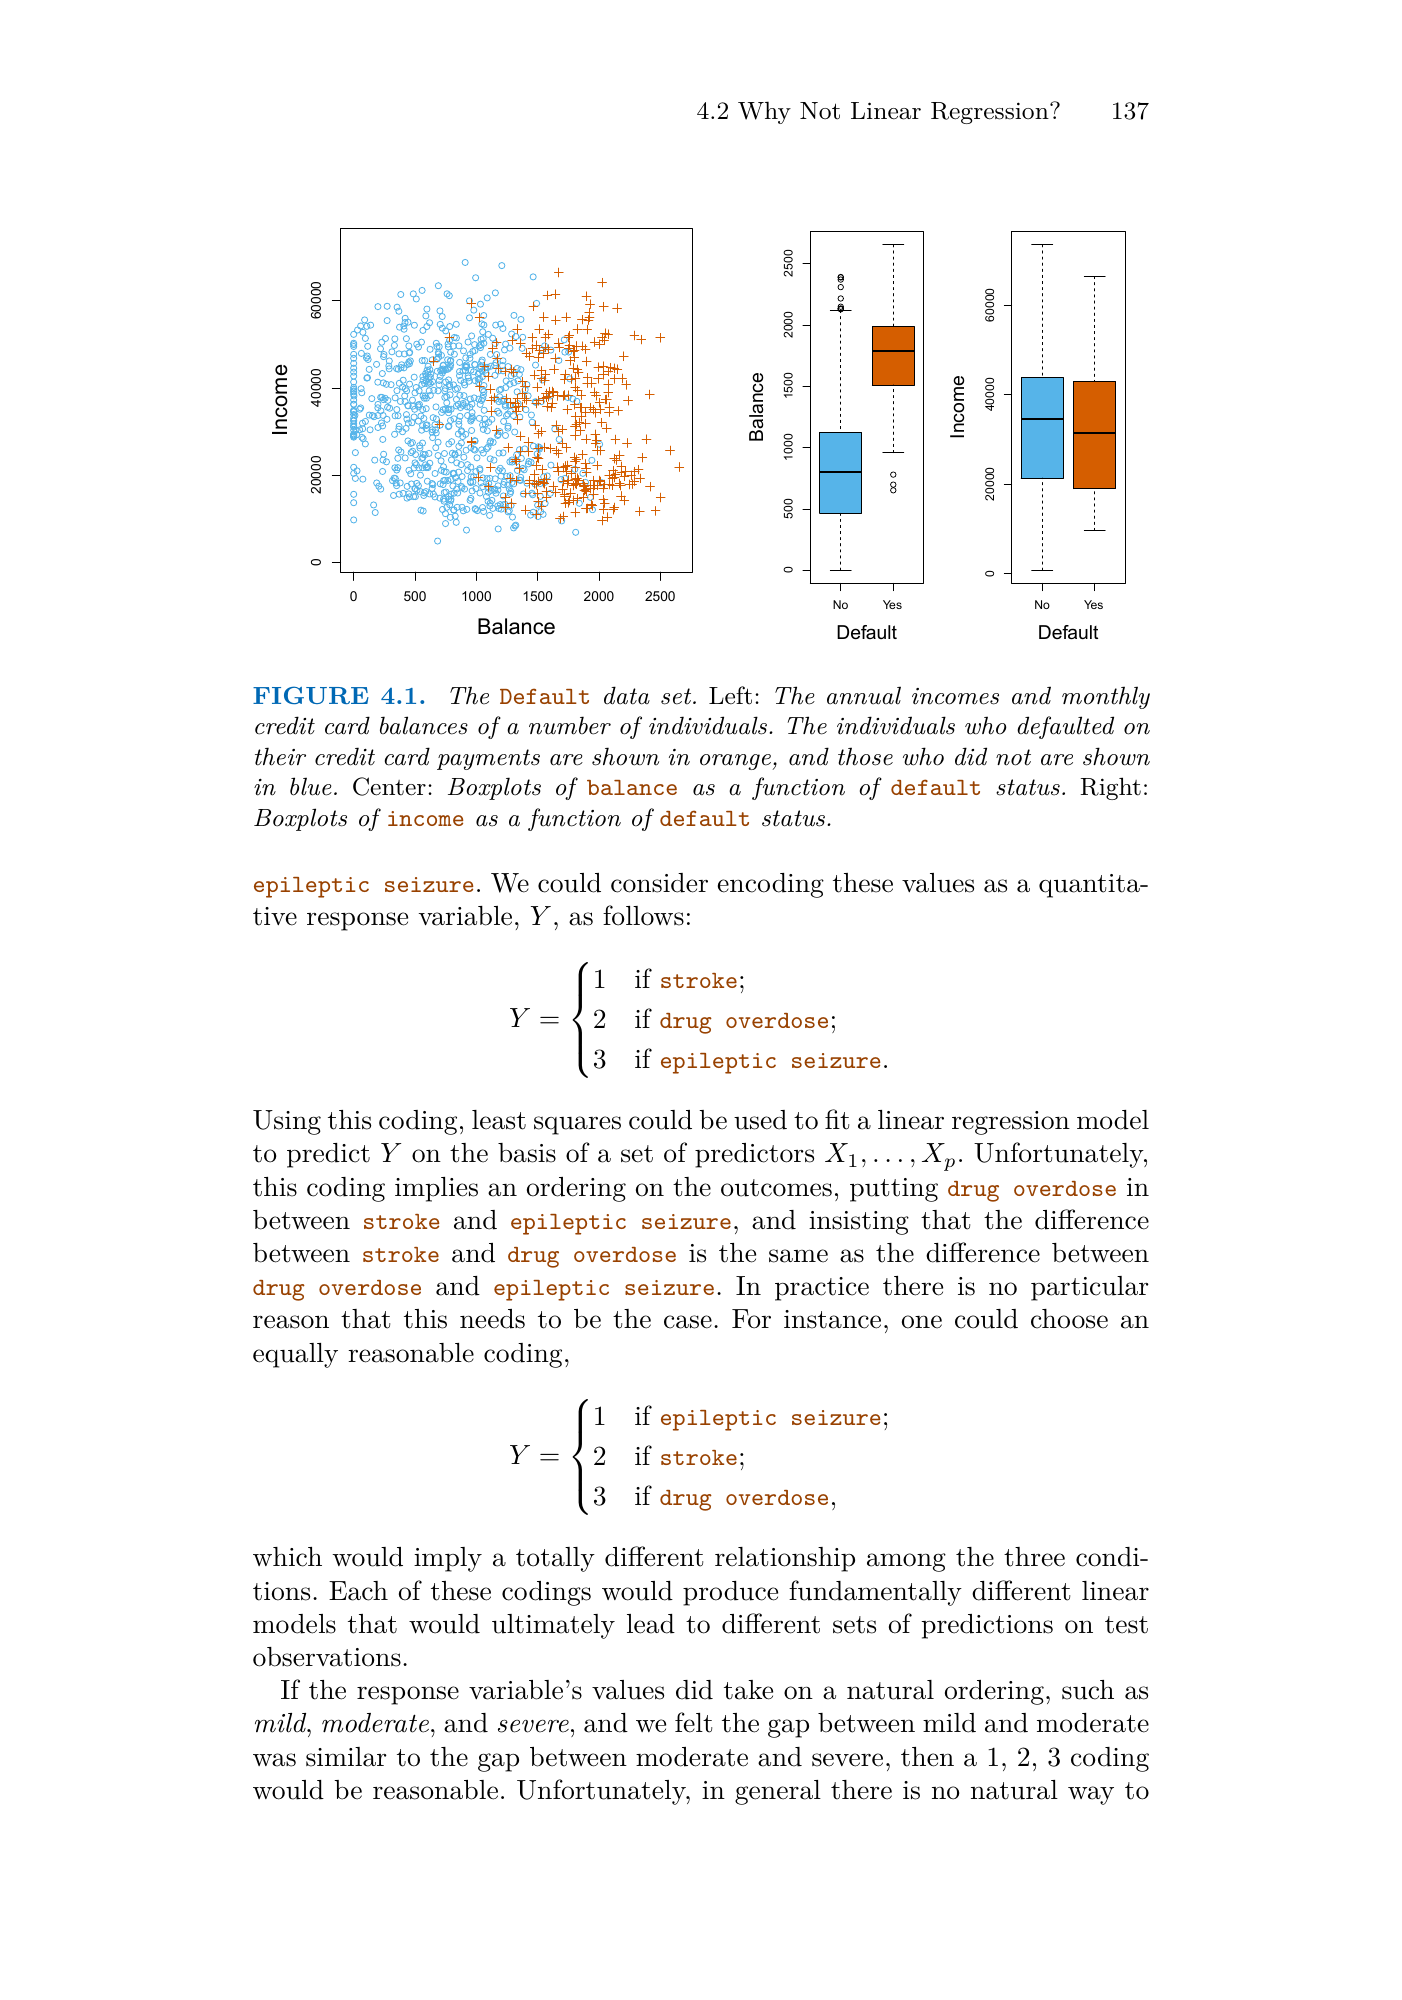

In [3]:
from pdf2image import convert_from_path
from IPython.display import display


pdf_path = "data/texts/ISLP_website-145-147.pdf"

images = convert_from_path(pdf_path, first_page=2, last_page=2)

display(images[0])

Strony są 3, na kazdej sa rozne wykresy i matematyczne notacje

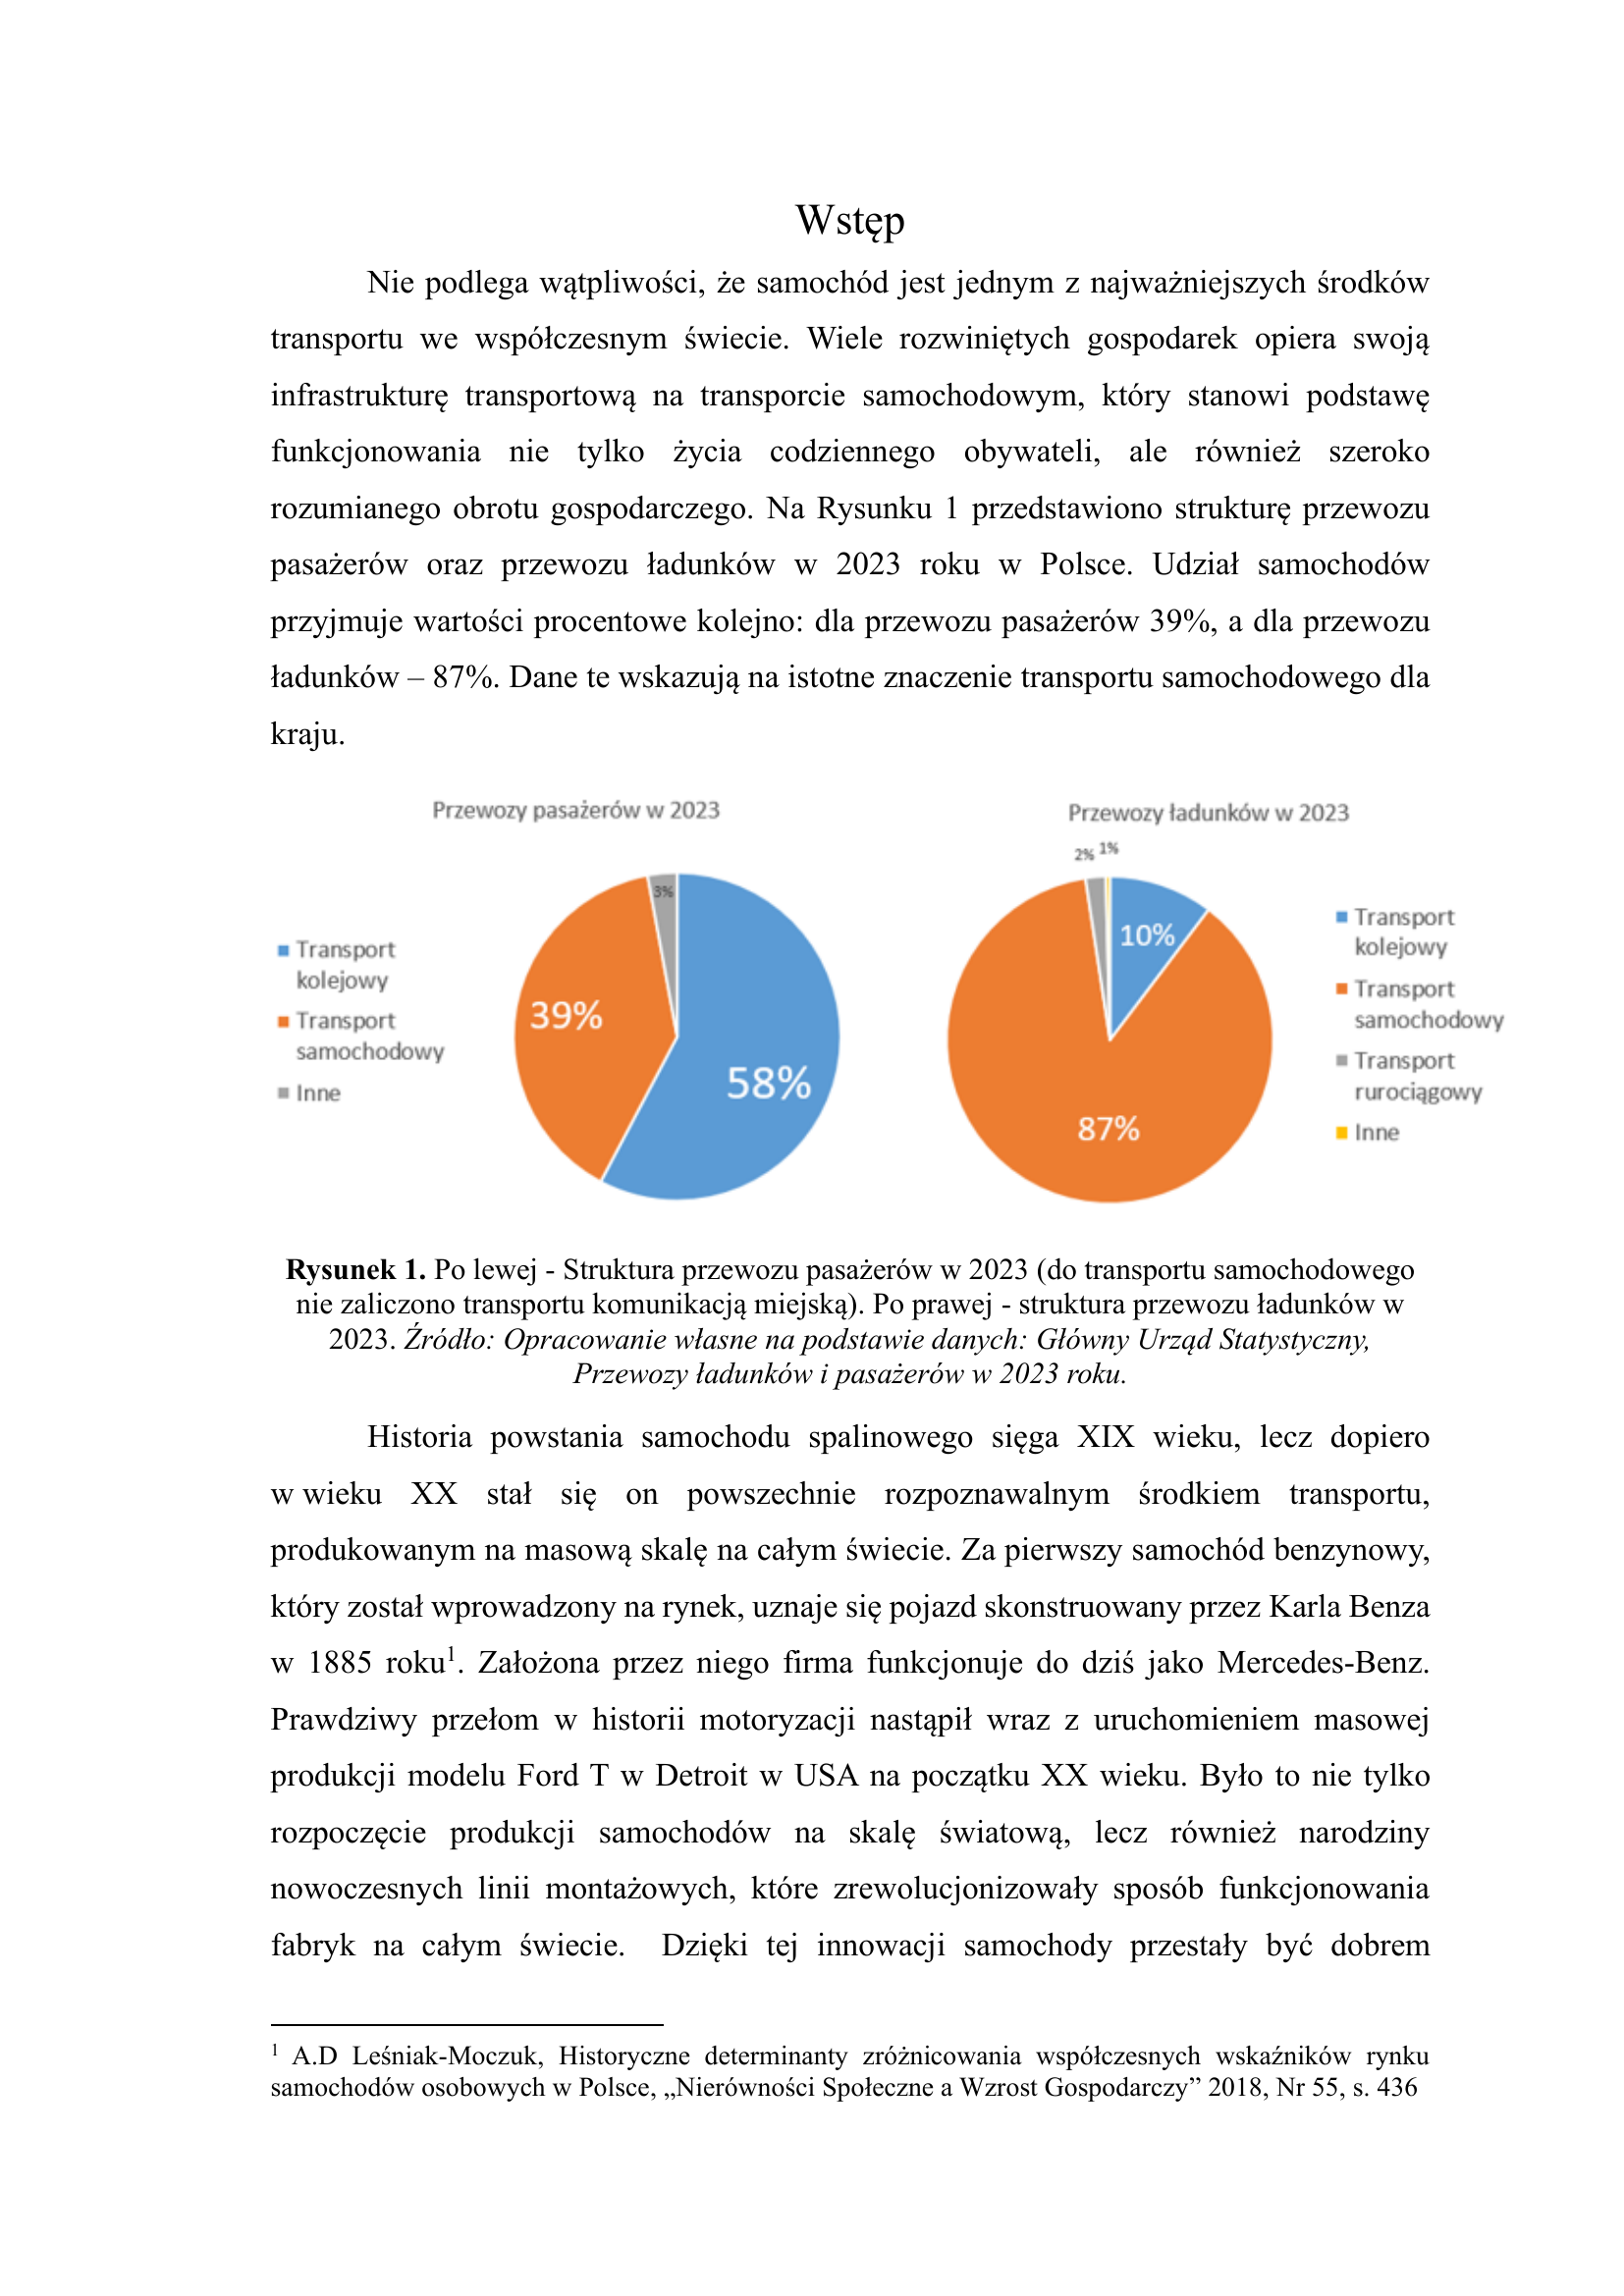

In [4]:
pdf_path2 = "data/texts/03250103859-4-7.pdf"

images = convert_from_path(pdf_path2, first_page=1, last_page=1)

display(images[0])

## 2.1 Biblioteka PyMuPDF

### 2.1.1 Pordęcznik Akademicki po Angielsku

#### 🛠️ Optymalizacja ekstrakcji dla biblioteki PyMuPDF (Podejście "Best Effort")

W przypadku dokumentów o złożonym układzie (np. dwukolumnowy tekst naukowy, wykresy), domyślna metoda `get_text()` zwraca tekst w kolejności strumienia danych, co często prowadzi do wymieszania treści z obu kolumn. Aby uzyskać miarodajny wynik porównywalny z narzędziami AI (Docling/Azure), zastosowano szereg transformacji i filtrów logicznych ("Pre-processing").

**Zastosowane usprawnienia w kodzie:**

1.  **Analiza układu (Layout Analysis):**
    * Użycie metody `page.get_text("blocks", sort=True)`. Flaga `sort=True` wymusza na bibliotece próbę odtworzenia naturalnej kolejności czytania (z góry na dół, z lewej do prawej), co jest kluczowe przy układzie wielokolumnowym.

2.  **Filtrowanie geometryczne (Header/Footer Removal):**
    * Zdefiniowano marginesy odcięcia (górne i dolne 5% strony). Bloki tekstu, których współrzędne `y0` i `y1` wskazują na nagłówek lub stopkę (np. numery stron, tytuły rozdziałów), są dynamicznie pomijane.

3.  **Eliminacja szumu (Noise Reduction):**
    * **Ignorowanie grafik:** Bloki oznaczone przez PyMuPDF jako obrazy (`block_type != 0`) są odrzucane, aby uniknąć błędów kodowania tekstu ukrytego pod obrazkami.
    * **Filtrowanie artefaktów:** Krótkie ciągi liczbowe (np. samotne numery stron, które "uciekły" filtrowi marginesów) są usuwane.

4.  **Normalizacja tekstu (Post-processing):**
    * **De-hyphenation:** Sklejanie wyrazów podzielonych myślnikiem na końcach linii (np. zamiana `classifi-\ncation` na `classification`). Jest to niezbędne do poprawnego obliczenia metryki podobieństwa (Levenshtein/Fuzz).
    * **Whitespace Normalization:** Usunięcie wielokrotnych spacji i znaków nowej linii, sprowadzając tekst do jednolitego ciągu ("single stream").

In [5]:


def clean_pymupdf_text(text):
    text = text.replace("-\n", "")
    text = " ".join(text.split())
    return text

results = []
print("Testowanie PyMuPDF (Best Effort)...")
start = time.perf_counter()

try:
    doc = fitz.open(pdf_path)
    text_parts = []
    
    for page in doc:
        blocks = page.get_text("blocks", sort=True)
        
        page_height = page.rect.height
        
        for b in blocks:
            x0, y0, x1, y1, text, block_no, block_type = b

            if block_type != 0:
                continue
                
            if y0 < page_height * 0.05 or y1 > page_height * 0.95:
                continue
            
            if len(text.strip()) < 3 and text.strip().isdigit():
                continue
                
            text_parts.append(text)

    raw_text = "\n".join(text_parts)
    
    text_pymu_cleaned = clean_pymupdf_text(raw_text)
    
    t_pymu = time.perf_counter() - start
    
    ground_truth_cleaned = " ".join(ground_truth_simple_2.split())
    score_pymu = fuzz.ratio(text_pymu_cleaned, ground_truth_cleaned)

except Exception as e:
    print(f"PyMuPDF Error: {e}")
    text_pymu_cleaned = ""
    t_pymu = 0
    score_pymu = 0

print(f"Time: {t_pymu:.4f} s")
print(f"Accuracy Score: {score_pymu:.2f}%")

print("-" * 30)
print("PREVIEW (First 500 chars):")
print(text_pymu_cleaned[:1500] + "...") 
print("-" * 30)



Testowanie PyMuPDF (Best Effort)...
Time: 0.0752 s
Accuracy Score: 93.18%
------------------------------
PREVIEW (First 500 chars):
1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have? 2. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user’s IP address, past transaction history, and so forth. 3. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not. Just as in the regression setting, in the classification setting we have a set of training observations (x1, y1), . . . , (xn, yn) that we can use to build a classifier. We want our classifier to perform well not only on the training data, but also on test observat

### 2.1.2 Praca naukowa po polsku

In [6]:

def clean_pymupdf_text(text):
    text = text.replace("-\n", "")
    text = " ".join(text.split())
    return text

results = []
print("Testowanie PyMuPDF (Best Effort)...")
start = time.perf_counter()

try:
    doc = fitz.open(pdf_path2)
    text_parts = []
    
    for page in doc:
        blocks = page.get_text("blocks", sort=True)
        
        page_height = page.rect.height
        
        for b in blocks:
            x0, y0, x1, y1, text, block_no, block_type = b

            if block_type != 0:
                continue
                
            if y0 < page_height * 0.05 or y1 > page_height * 0.95:
                continue
            
            if len(text.strip()) < 3 and text.strip().isdigit():
                continue
                
            text_parts.append(text)

    raw_text = "\n".join(text_parts)
    
    text_pymu_cleaned = clean_pymupdf_text(raw_text)
    
    t_pymu = time.perf_counter() - start
    
    ground_truth_cleaned = " ".join(ground_truth_simple_1.split())
    score_pymu = fuzz.ratio(text_pymu_cleaned, ground_truth_cleaned)

except Exception as e:
    print(f"PyMuPDF Error: {e}")
    text_pymu_cleaned = ""
    t_pymu = 0
    score_pymu = 0

print(f"Time: {t_pymu:.4f} s")
print(f"Accuracy Score: {score_pymu:.2f}%")

print("-" * 30)
print("PREVIEW (First 500 chars):")
print(text_pymu_cleaned[:1500] + "...") 
print("-" * 30)



Testowanie PyMuPDF (Best Effort)...
Time: 0.0186 s
Accuracy Score: 95.97%
------------------------------
PREVIEW (First 500 chars):
Wstęp Nie podlega wątpliwości, że samochód jest jednym z najważniejszych środków transportu we współczesnym świecie. Wiele rozwiniętych gospodarek opiera swoją infrastrukturę transportową na transporcie samochodowym, który stanowi podstawę funkcjonowania nie tylko życia codziennego obywateli, ale również szeroko rozumianego obrotu gospodarczego. Na Rysunku 1 przedstawiono strukturę przewozu pasażerów oraz przewozu ładunków w 2023 roku w Polsce. Udział samochodów przyjmuje wartości procentowe kolejno: dla przewozu pasażerów 39%, a dla przewozu ładunków – 87%. Dane te wskazują na istotne znaczenie transportu samochodowego dla kraju. Rysunek 1. Po lewej - Struktura przewozu pasażerów w 2023 (do transportu samochodowego nie zaliczono transportu komunikacją miejską). Po prawej - struktura przewozu ładunków w 2023. Źródło: Opracowanie własne na podstawie danych:

## 2.2 PDFplumber

### 2.2.1 Pordęcznik Akademicki po Angielsku

#### 🛠️ Optymalizacja ekstrakcji dla biblioteki PDFPlumber (Podejście "Best Effort")

PDFPlumber jest narzędziem bardziej zaawansowanym niż PyMuPDF w kontekście analizy układu (lepiej radzi sobie z tabelami), ale jest znacznie wolniejszy. Aby poprawić jakość wyniku i uniknąć "szumu" z marginesów, zastosowano filtrowanie przestrzenne.

**Zastosowane usprawnienia w kodzie:**

1.  **Geometryczne przycinanie strony (Cropping):**
    * Zamiast przetwarzać całą stronę, zastosowano metodę `.crop()`, definiując obszar zainteresowania (ROI - Region of Interest).
    * Odrzucono górne i dolne 5% wysokości strony. Pozwala to na **fizyczne usunięcie** numerów stron, stopek i tytułów rozdziałów jeszcze przed rozpoczęciem analizy tekstu. Dzięki temu algorytm ekstrakcji nie "widzi" tych elementów i nie miesza ich z treścią akapitów.

2.  **Inteligentna ekstrakcja:**
    * Wykorzystano domyślną heurystykę `.extract_text()`, która w PDFPlumberze dobrze radzi sobie z wykrywaniem odstępów między wyrazami (word spacing), co jest kluczowe przy justowanym tekście.

3.  **Czyszczenie post-ekstrakcyjne:**
    * **Whitespace Normalization:** PDFPlumber ma tendencję do generowania wielu spacji w celu odwzorowania układu wizualnego (np. wcięć). Zredukowano je do pojedynczych spacji, aby uzyskać ciągły tekst.
    * **De-hyphenation:** Usunięto podziały wyrazów (myślniki na końcu linii), aby umożliwić poprawne porównanie z wzorcem.

In [7]:

def clean_plumber_text(text):
    if not text: return ""
    text = text.replace("-\n", "")
    text = " ".join(text.split())
    return text

results = []
print("Testowanie pdfplumber (Best Effort)...")
start = time.perf_counter()

text_plumber = ""
t_plumber = 0
score_plumber = 0

try:
    with pdfplumber.open(pdf_path) as doc:
        text_parts = []
        for page in doc.pages:
        
            width = page.width
            height = page.height
            
            crop_box = (0, height * 0.05, width, height * 0.95)
            
            try:
                cropped_page = page.crop(crop_box)
                
                txt = cropped_page.extract_text()
                
                if txt:
                    text_parts.append(txt)
            except ValueError:
                txt = page.extract_text()
                if txt:
                    text_parts.append(txt)

    t_plumber = time.perf_counter() - start
    
    raw_text = "\n".join(text_parts)
    text_plumber_cleaned = clean_plumber_text(raw_text)
    
    # Porównanie z Ground Truth (znormalizowanym)
    ground_truth_cleaned = " ".join(ground_truth_simple_2.split())
    score_plumber = fuzz.ratio(text_plumber_cleaned, ground_truth_cleaned)

except Exception as e:
    print(f"pdfplumber Error: {e}")
    text_plumber_cleaned = ""
    score_plumber = 0.0

# --- Wyświetlanie wyników ---
print(f"Time: {t_plumber:.4f} s")
print(f"Accuracy Score: {score_plumber:.2f}%")

print("-" * 30)
print("PREVIEW (First 500 chars):")
print(text_plumber_cleaned[:500] + "...")
print("-" * 30)

Testowanie pdfplumber (Best Effort)...
Time: 0.5302 s
Accuracy Score: 91.60%
------------------------------
PREVIEW (First 500 chars):
136 4. Classification 1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have? 2. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user’s IP address, past transaction history, and so forth. 3. On the basis of DNA sequence data for a number of patients with andwithoutagiv...
------------------------------


### 2.2.2 Artykuł naukowy po polsku

In [8]:

def clean_plumber_text(text):
    if not text: return ""
    text = text.replace("-\n", "")
    text = " ".join(text.split())
    return text

results = []
print("Testowanie pdfplumber (Best Effort)...")
start = time.perf_counter()

text_plumber = ""
t_plumber = 0
score_plumber = 0

try:
    with pdfplumber.open(pdf_path2) as doc:
        text_parts = []
        for page in doc.pages:
        
            width = page.width
            height = page.height
            
            crop_box = (0, height * 0.05, width, height * 0.95)
            
            try:
                cropped_page = page.crop(crop_box)
                
                txt = cropped_page.extract_text()
                
                if txt:
                    text_parts.append(txt)
            except ValueError:
                txt = page.extract_text()
                if txt:
                    text_parts.append(txt)

    t_plumber = time.perf_counter() - start
    
    raw_text = "\n".join(text_parts)
    text_plumber_cleaned = clean_plumber_text(raw_text)
    
    # Porównanie z Ground Truth (znormalizowanym)
    ground_truth_cleaned = " ".join(ground_truth_simple_1.split())
    score_plumber = fuzz.ratio(text_plumber_cleaned, ground_truth_cleaned)

except Exception as e:
    print(f"pdfplumber Error: {e}")
    text_plumber_cleaned = ""
    score_plumber = 0.0

# --- Wyświetlanie wyników ---
print(f"Time: {t_plumber:.4f} s")
print(f"Accuracy Score: {score_plumber:.2f}%")

print("-" * 30)
print("PREVIEW (First 500 chars):")
print(text_plumber_cleaned[:500] + "...")
print("-" * 30)

Testowanie pdfplumber (Best Effort)...
Time: 0.3555 s
Accuracy Score: 95.98%
------------------------------
PREVIEW (First 500 chars):
Wstęp Nie podlega wątpliwości, że samochód jest jednym z najważniejszych środków transportu we współczesnym świecie. Wiele rozwiniętych gospodarek opiera swoją infrastrukturę transportową na transporcie samochodowym, który stanowi podstawę funkcjonowania nie tylko życia codziennego obywateli, ale również szeroko rozumianego obrotu gospodarczego. Na Rysunku 1 przedstawiono strukturę przewozu pasażerów oraz przewozu ładunków w 2023 roku w Polsce. Udział samochodów przyjmuje wartości procentowe kol...
------------------------------


## 2.3 Docling

### 2.3.1 Pordęcznik Akademicki po Angielsku

In [9]:
results = []
start = time.perf_counter()
text_docling = ""
t_docling = None
score_docling = None

try:
    converter = DocumentConverter()
    res = converter.convert(pdf_path)
    try:
        md = res.document.export_to_markdown()
    except Exception:
        md = ""
        for page in res.document.pages:
            txt = page.export_to_markdown()
            if txt:
                md += txt + "\n"
    text_docling = md
    t_docling = time.perf_counter() - start
    score_docling = fuzz.ratio(text_docling.strip(), ground_truth_simple_2.strip()) if text_docling.strip() else 0.0
except Exception as e:
    print(f"Docling Error: {e}")
    t_docling = time.perf_counter() - start
    score_docling = 0.0

print(f"time:{t_docling}")
print(f"score:{score_docling}")
print("\n")


print(text_docling[:1500]) 

time:7.767676666990155
score:74.52993732497666


1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have?
2. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user's IP address, past transaction history, and so forth.
3. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not.

Just as in the regression setting, in the classification setting we have a set of training observations ( x 1 , y 1 ) , . . . , ( x n , y n ) that we can use to build a classifier. We want our classifier to perform well not only on the training data, but also on test observations that were not used to train the classifier.

It is worth noting th

Zaleta: Docling bezbłędnie złożył kolumny (tekst o "DNA sequence" łączy się logicznie, nie miesza się z drugą kolumną).

Wada: Docling w wersji podstawowej "poddaje się" przy skomplikowanych wzorach matematycznych (formula-not-decoded), podczas gdy człowiek (Ground Truth) starałby się je zapisać przybliżonym tekstem (np. "Y = 1"). To spowoduje, że Twój Score dla Doclinga spadnie w tym konkretnym pliku.

Flow: Docling wstawia podpisy rysunków (FIGURE 4.1) w miejscu ich występowania w strumieniu ("flow"), co przerywa ciągłość zdania. W Twoim tekście widać: ...drug overdose, and FIGURE 4.1... epileptic seizure. Zdanie zostało przecięte przez opis obrazka.

### 2.3.2 Praca naukowa po polsku

In [10]:
results = []
start = time.perf_counter()
text_docling = ""
t_docling = None
score_docling = None

try:
    converter = DocumentConverter()
    res = converter.convert(pdf_path2)
    try:
        md = res.document.export_to_markdown()
    except Exception:
        md = ""
        for page in res.document.pages:
            txt = page.export_to_markdown()
            if txt:
                md += txt + "\n"
    text_docling = md
    t_docling = time.perf_counter() - start
    score_docling = fuzz.ratio(text_docling.strip(), ground_truth_simple_1.strip()) if text_docling.strip() else 0.0
except Exception as e:
    print(f"Docling Error: {e}")
    t_docling = time.perf_counter() - start
    score_docling = 0.0

print(f"time:{t_docling}")
print(f"score:{score_docling}")
print("\n")


print(text_docling[:1500]) 

time:4.555241958994884
score:92.347891004106


• Transport kolejowy

• Transport samochodowy

• Inne

Przewozy pasażerów w 2023

3%

Przewozy tadunków w 2023

2% 1%

10%

## Wstęp

• Transport kolejowy

• Transport

Nie podlega wątpliwości, że samochód jest jednym z najważniejszych środków transportu  we  współczesnym  świecie.  Wiele  rozwiniętych  gospodarek  opiera  swoją infrastrukturę  transportową  na  transporcie  samochodowym,  który  stanowi  podstawę funkcjonowania nie tylko życia codziennego obywateli, ale również szeroko rozumianego obrotu gospodarczego. Na Rysunku 1 przedstawiono strukturę przewozu pasażerów  oraz  przewozu  ładunków  w  2023  roku  w  Polsce.  Udział  samochodów przyjmuje wartości procentowe kolejno: dla przewozu pasażerów 39%, a dla przewozu ładunków - 87%. Dane te wskazują na istotne znaczenie transportu samochodowego dla kraju. Inne

Rysunek 1. Po lewej - Struktura przewozu pasażerów w 2023 (do transportu samochodowego nie zaliczono transportu komunika

## 2.4 Azure Document Inteligence

### 2.4.1 Pordęcznik Akademicki po Angielsku

In [11]:
def clean_markdown_text(text):
    if not text: return ""
    text = re.sub(r'(\*\*|__)(.*?)\1', r'\2', text) 
    text = re.sub(r'#+\s+', '', text) 
    text = re.sub(r'!\[.*?\]\(.*?\)', '', text) 
    text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text) 
    text = text.replace('|', ' ').replace('---', '')
    # Normalizacja spacji
    text = " ".join(text.split())
    return text

def run_azure_book_test(pdf_path, ground_truth_text):
    print(f"--- ☁️ Azure AI (Book Mode): {os.path.basename(pdf_path)} ---")
    print("(Wysyłanie pliku do chmury...)")
    
    start_time = time.perf_counter()
    extracted_text_cleaned = ""
    
    try:
        client = DocumentIntelligenceClient(
            endpoint=AZURE_ENDPOINT, 
            credential=AzureKeyCredential(AZURE_KEY)
        )
        
        with open(pdf_path, "rb") as f:
            # 1. Wymuszamy format Markdown dla zachowania kolejności czytania (szpalty!)
            poller = client.begin_analyze_document(
                "prebuilt-layout", 
                body=f,
                content_type="application/pdf",
                output_content_format="markdown" 
            )
        
        result = poller.result()
        
        # 2. Pobieramy całą treść (content), a nie tabele
        raw_text = result.content
        
        # 3. Czyścimy wynik
        extracted_text_cleaned = clean_markdown_text(raw_text)
        
        # Sukces
        duration = time.perf_counter() - start_time
        
        # 4. Obliczamy wynik (jeśli podano ground truth)
        score = 0.0
        if ground_truth_text:
            # Normalizujemy też ground truth dla pewności
            gt_cleaned = " ".join(ground_truth_text.split())
            score = fuzz.ratio(extracted_text_cleaned, gt_cleaned)
            
        return extracted_text_cleaned, duration, score

    except Exception as e:
        print(f"❌ Błąd Azure: {e}")
        return "", time.perf_counter() - start_time, 0.0

text_azure, t_azure, score_azure = run_azure_book_test(pdf_path, ground_truth_simple_2)
print("\n" + "="*30)
print(f"Time: {t_azure:.4f} s")
print(f"Accuracy Score: {score_azure:.2f}%")
print("="*30)
print("PREVIEW (First 500 chars):")
print(text_azure[:1500] + "...")

--- ☁️ Azure AI (Book Mode): ISLP_website-145-147.pdf ---
(Wysyłanie pliku do chmury...)

Time: 7.1525 s
Accuracy Score: 68.53%
PREVIEW (First 500 chars):
<!-- PageNumber="136" --> <!-- PageHeader="4. Classification" --> 1\. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have? 2\. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user's IP address, past transaction history, and so forth. 3\. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not. Just as in the regression setting, in the classification setting we have a set of training observations (x1,91), ... , (In, yn) that we can use to build a classifier. We wan

W przypadku biblioteki Azure Document Intelligence, niski wynik liczbowy (68%) jest paradoksalnie dowodem na jej wyższość technologiczną.

Biblioteka ta, zamiast zwracać "płaski" tekst (jak PyMuPDF), zwróciła bogaty semantycznie dokument w formacie Markdown, zawierający ukryte tagi metadanych (np. ``).

Prosta metryka Levenshteina potraktowała te dodatkowe, wartościowe informacje jako błędy (szum). W rzeczywistym zastosowaniu (np. zasilanie bazy wiedzy AI/RAG), zdolność Azure do oddzielenia treści od nagłówków i numerów stron jest kluczową zaletą, mimo że zaniżyła wynik w surowym teście porównawczym."

### 2.4.2 Praca naukowa po polsku

In [12]:
text_azure, t_azure, score_azure = run_azure_book_test(pdf_path2, ground_truth_simple_1)
print("\n" + "="*30)
print(f"Time: {t_azure:.4f} s")
print(f"Accuracy Score: {score_azure:.2f}%")
print("="*30)
print("PREVIEW (First 500 chars):")
print(text_azure[:1500] + "...")

--- ☁️ Azure AI (Book Mode): 03250103859-4-7.pdf ---
(Wysyłanie pliku do chmury...)

Time: 6.8638 s
Accuracy Score: 63.59%
PREVIEW (First 500 chars):
Wstęp Nie podlega wątpliwości, że samochód jest jednym z najważniejszych środków transportu we współczesnym świecie. Wiele rozwiniętych gospodarek opiera swoją infrastrukturę transportową na transporcie samochodowym, który stanowi podstawę funkcjonowania nie tylko życia codziennego obywateli, ale również szeroko rozumianego obrotu gospodarczego. Na Rysunku 1 przedstawiono strukturę przewozu pasażerów oraz przewozu ładunków w 2023 roku w Polsce. Udział samochodów przyjmuje wartości procentowe kolejno: dla przewozu pasażerów 39%, a dla przewozu ładunków - 87%. Dane te wskazują na istotne znaczenie transportu samochodowego dla kraju. <figure> <figcaption>Rysunek 1. Po lewej - Struktura przewozu pasażerów w 2023 (do transportu samochodowego nie zaliczono transportu komunikacją miejską). Po prawej - struktura przewozu ładunków w</figcaption> P

## 2.5 Podsumowanie czytania ksiązek

# Rozdział 3: Ekstrakcja danych strukturalnych (Faktury/Tabele)

W tym segmencie chcialbym sprawdzic jak biblioteki radzą sobie z problemem faktur, ktore są złozonymi dokumentami. Posiadaja numer faktury, odbiorce, firme i najwazniejsze - rzeczy, ktore sa wystawione na fakturze. Czesto sa one podane w formie tabelki, choc nie zawsze. Przykladowy i testowany pdf faktury ukazuje ponizej:

TO PONIZEJ TO FAKTURA PROSTA I PRZYJEMNA

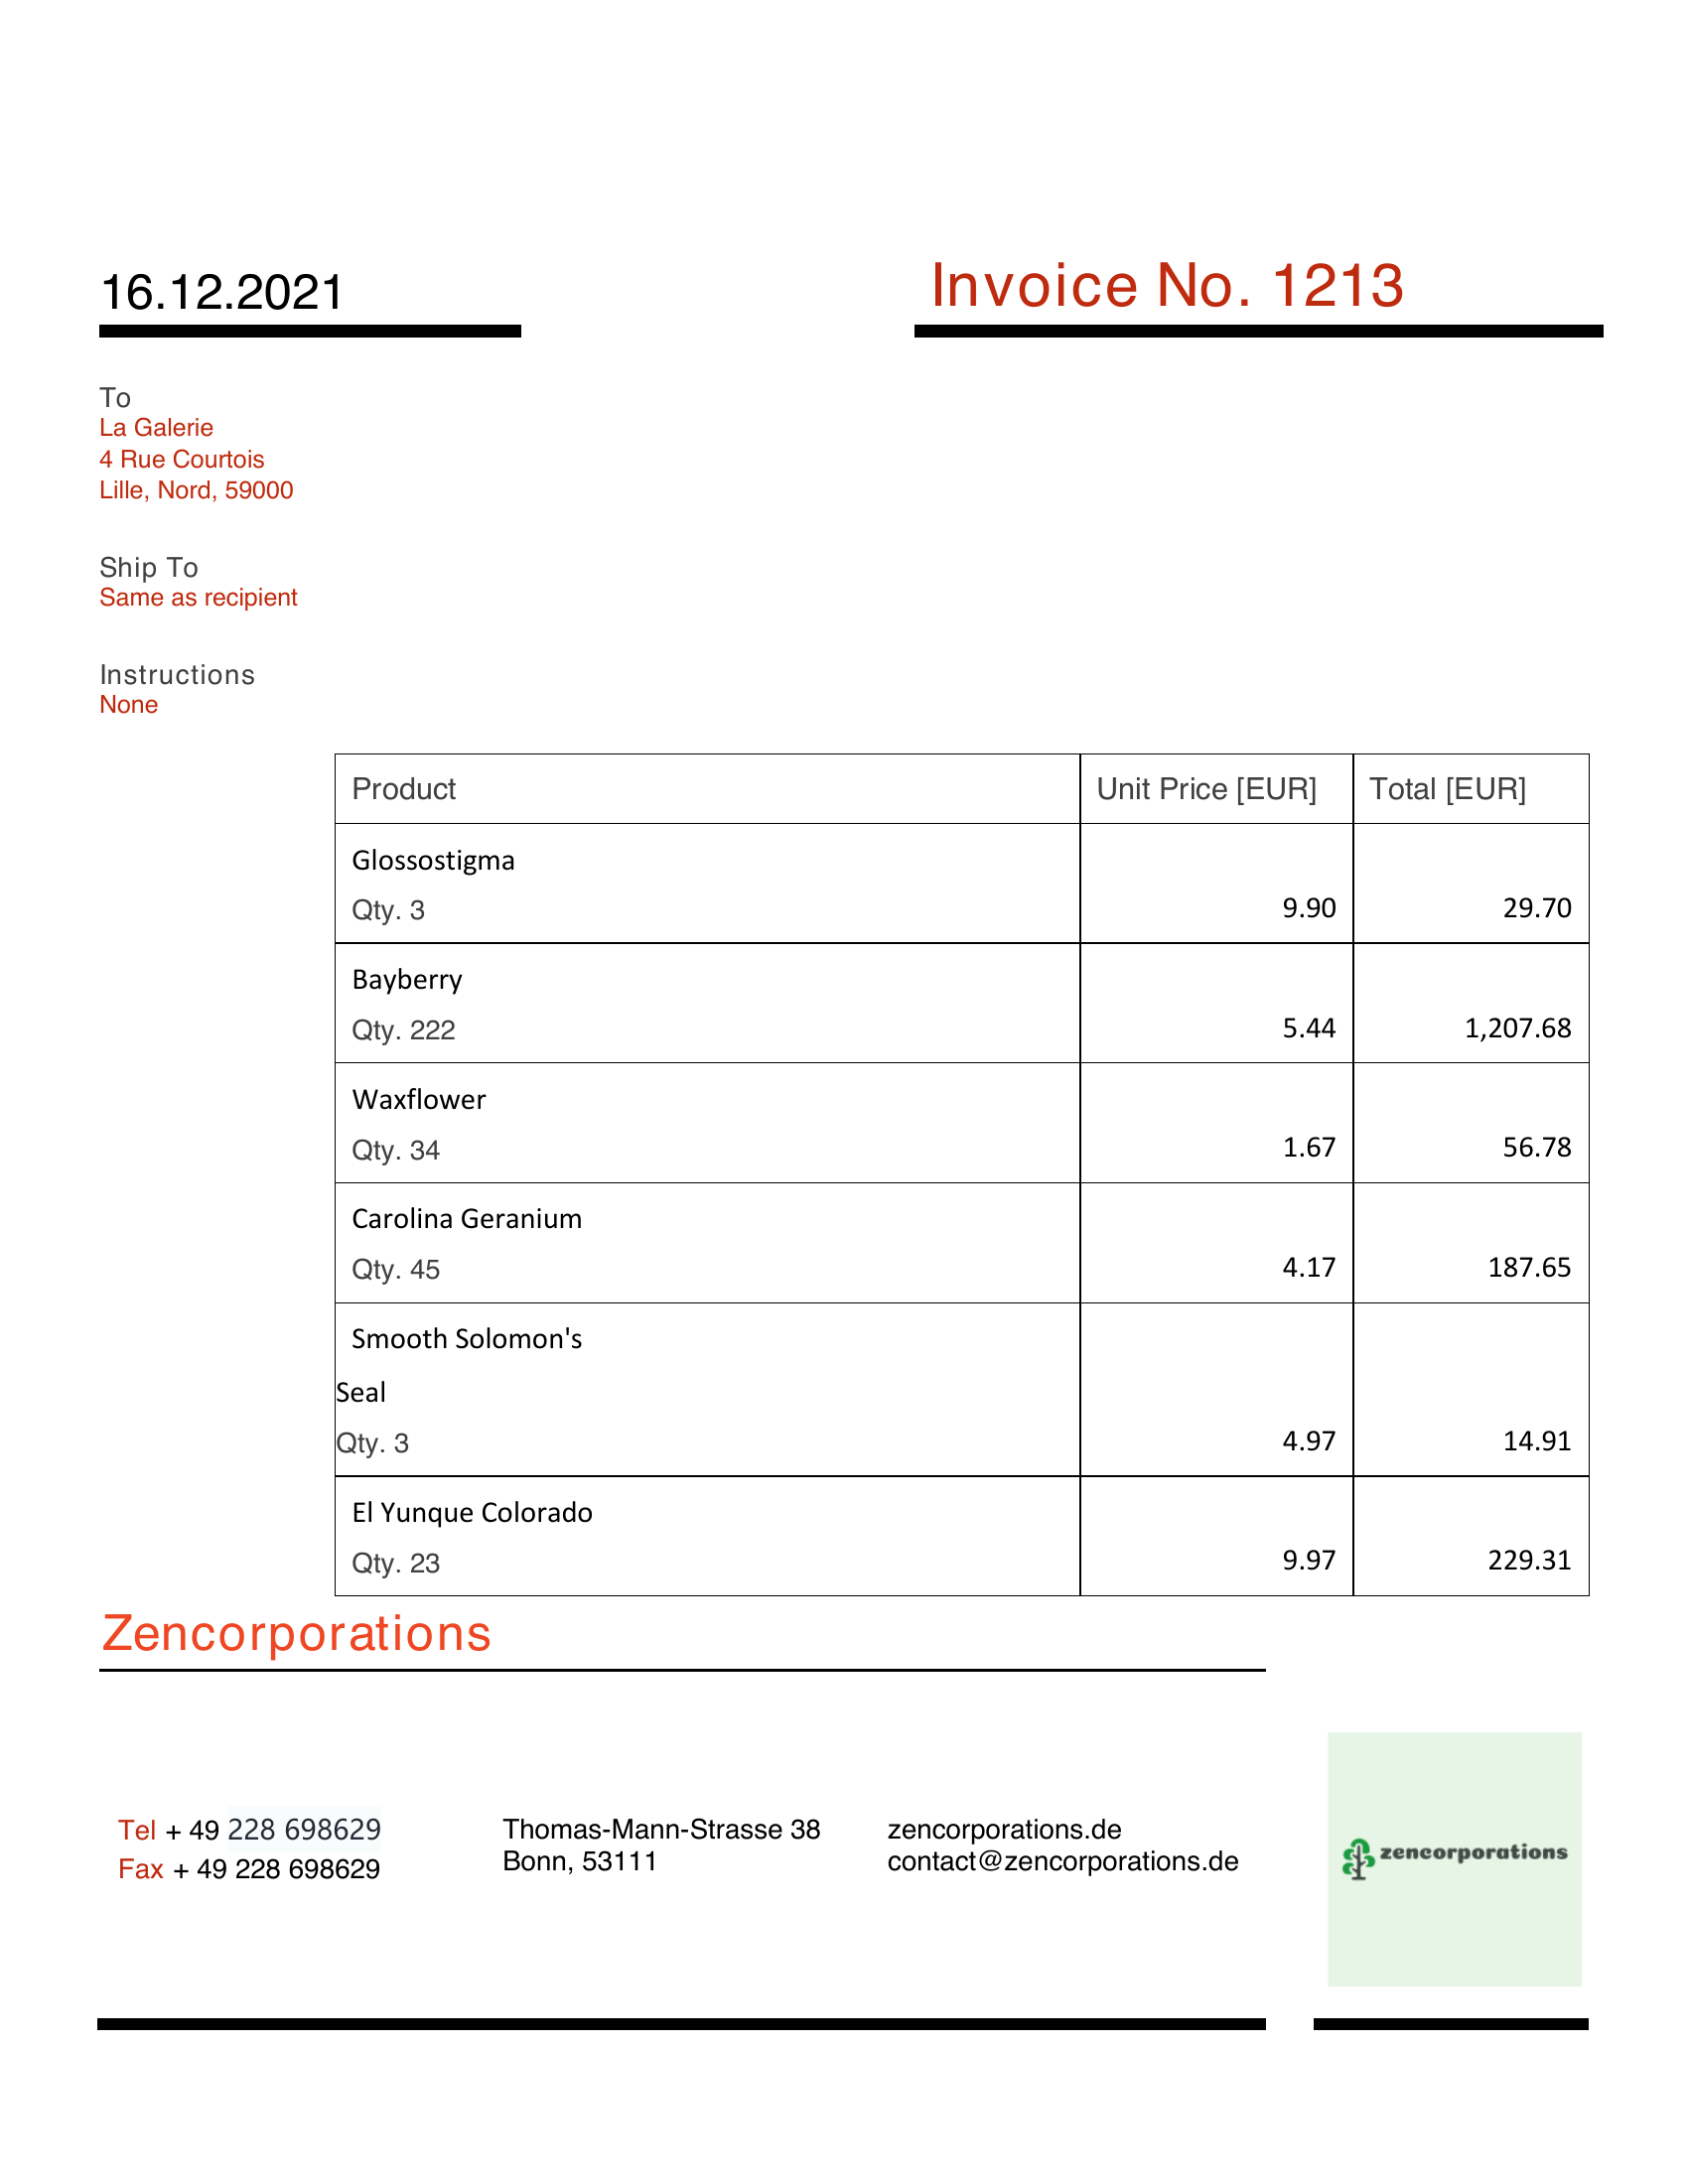

In [13]:
pdf_path_1 = "data/invoices/invoice-1-3.pdf"

images = convert_from_path(pdf_path_1, first_page=1, last_page=1)

display(images[0])

TO PONIZEJ TO FAKTURA CIEZKA I BEZ LINI

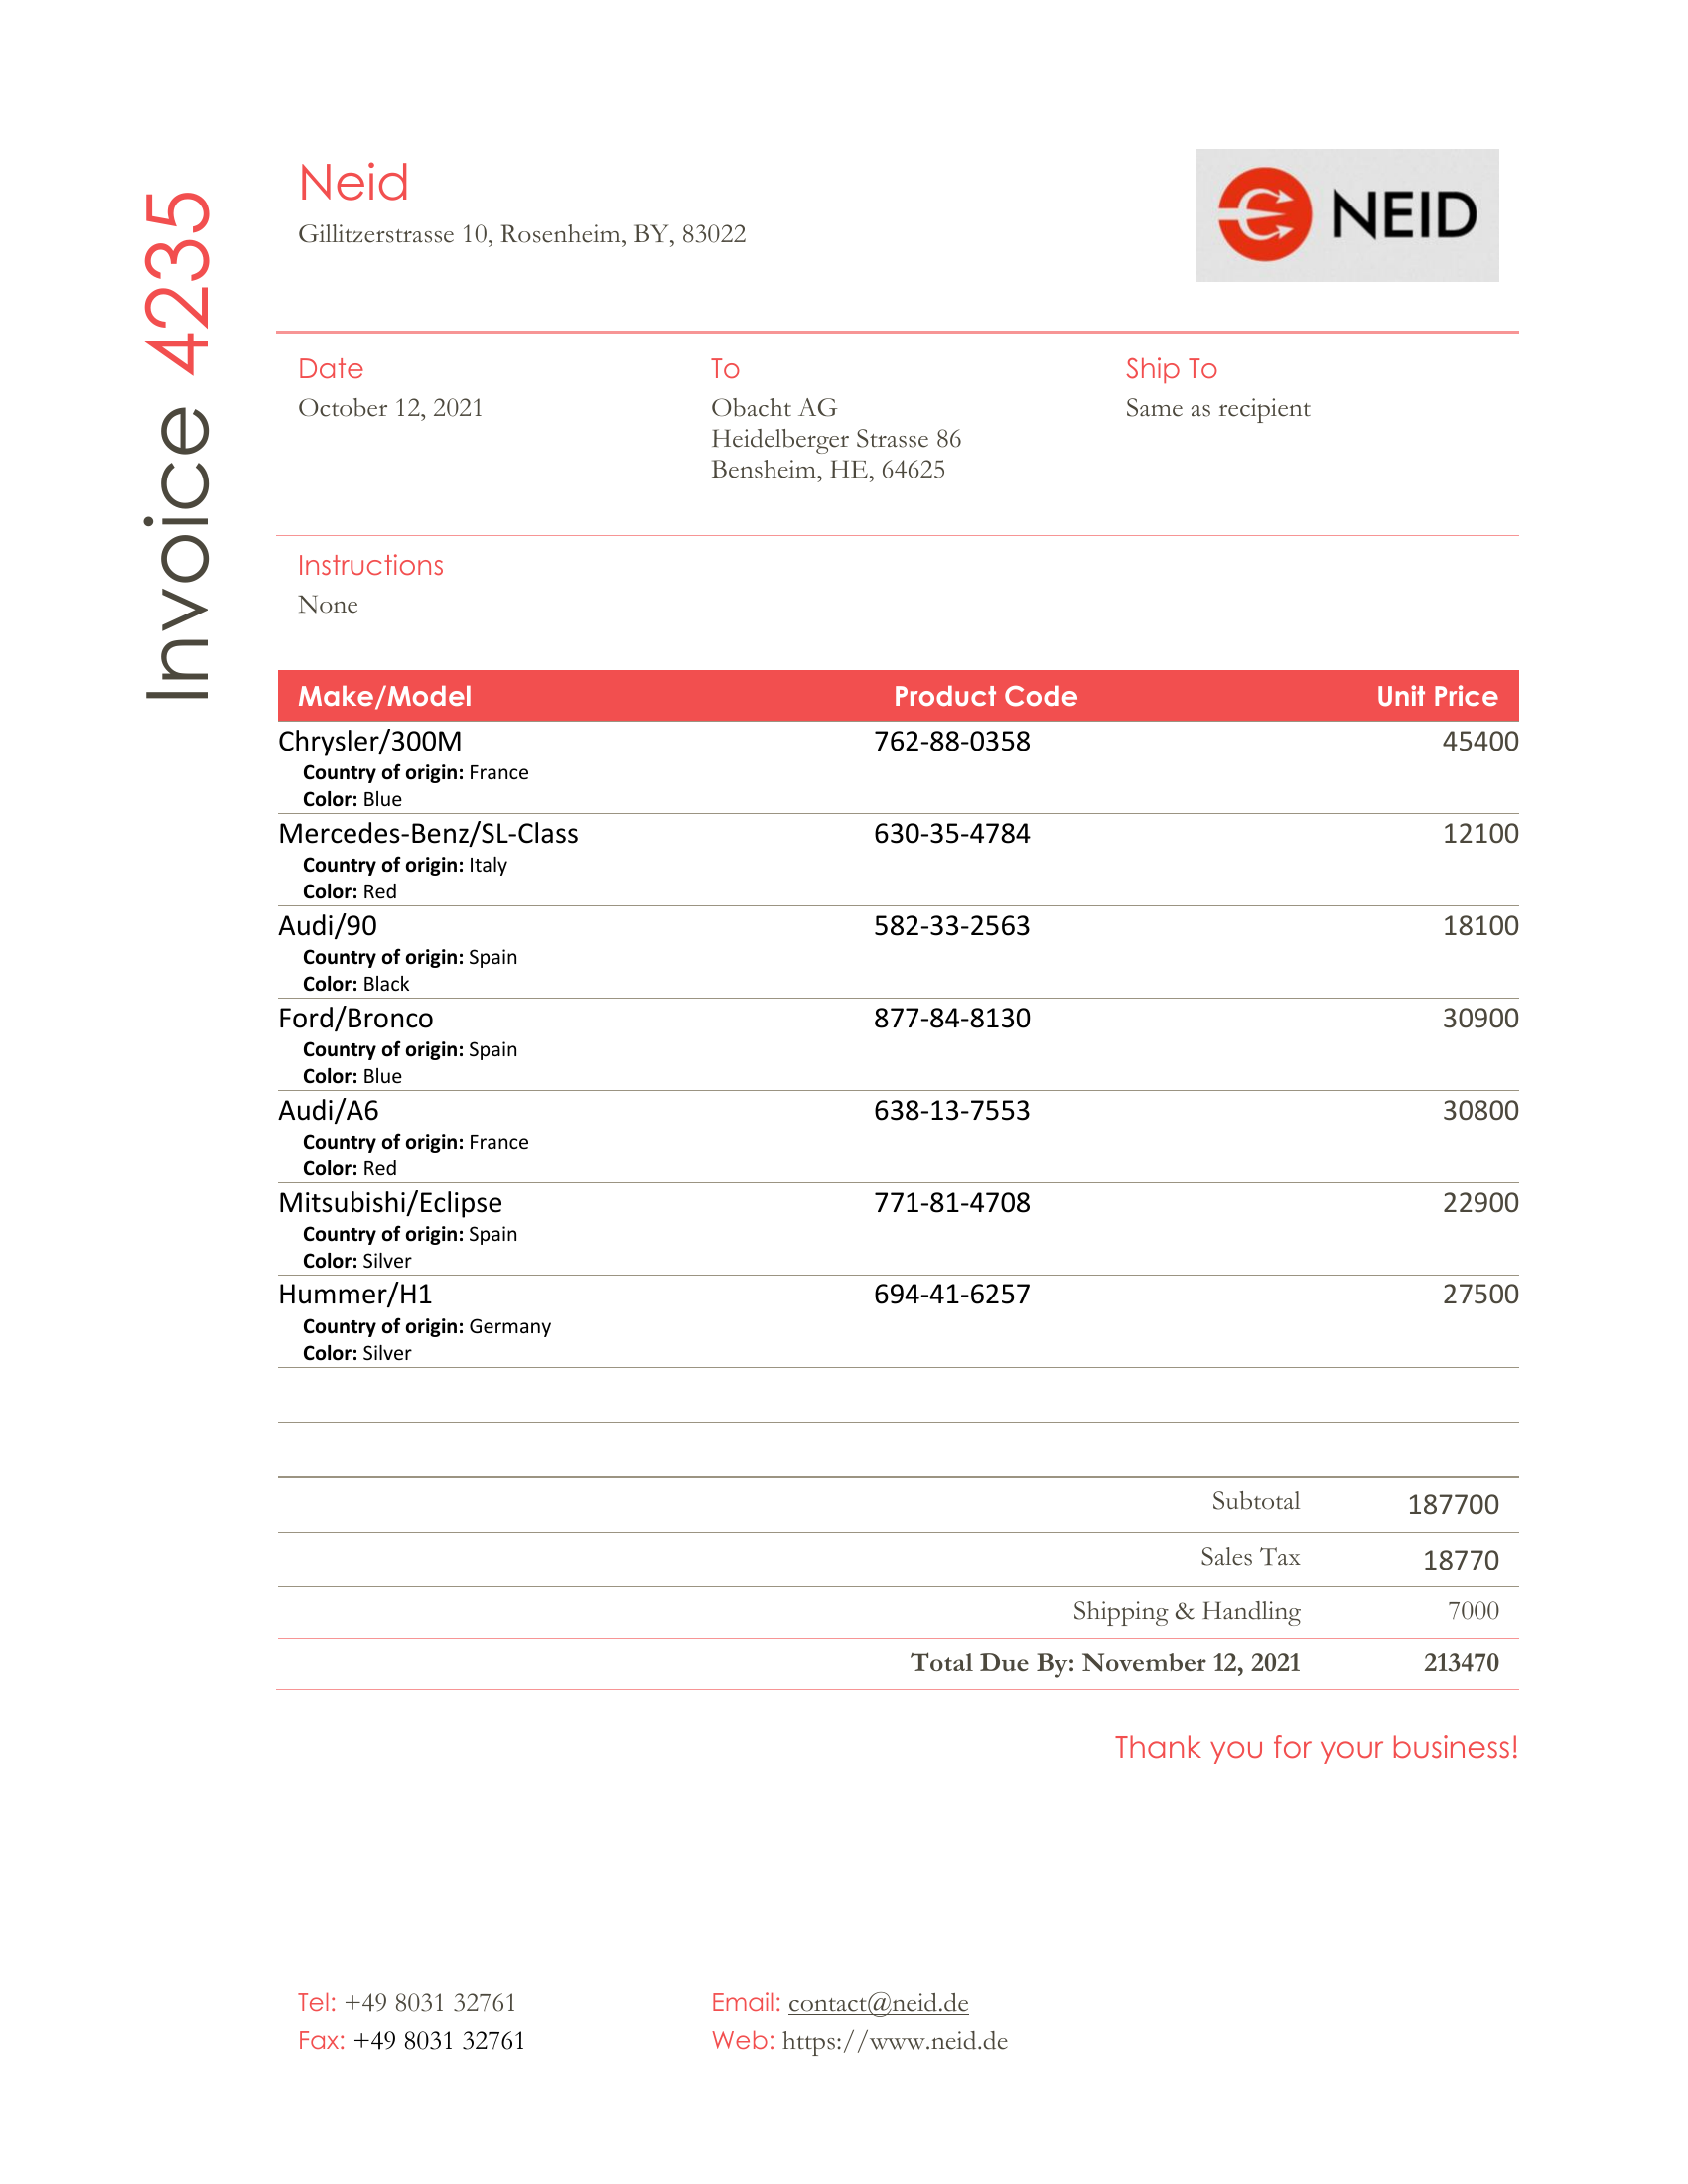

In [14]:
pdf_path = "data/invoices/invoice-3-0.pdf"

images = convert_from_path(pdf_path, first_page=1, last_page=1)

display(images[0])

## 3.1 PyMuPDF

Jako ze ciezko jest przetestowac skutecznosc bibliotek na fakturach, bo wymagaloby to bardzo duzej ilosci plikow z labelami to w tej pracy skupie sie tylko na tym, czy bibiolteka (bez tuningu) znalazla numer faktury, date faktury i najwazniejsze - tabelkę z pozycjami faktury.

### 3.1.1 Faktura prosta

In [15]:
# doc=fitz.open("data/invoices/invoice-1-3.pdf")
# page=doc[0]

# tabs = page.find_tables(strategy='lines')

# if tabs.tables:
#     for table in tabs.tables:
#         df=table.to_pandas()
#         display(df)


def extract_metadata_pymupdf(text):
    """
    Funkcja pomocnicza próbująca znaleźć dane za pomocą Regex (sztywne reguły).
    Działa tylko wtedy, gdy faktura pasuje do wzorca!
    """
    metadata = {
        "Numer faktury": None,
        "Data wystawienia": None,
        "Suma (Brutto)": None,
    }
    
    nr_match = re.search(r"(?:Faktura|Nr|Numer|No.)\s*(?:nr)?\s*[:.]?\s*([A-Za-z0-9/-]+)", text, re.IGNORECASE)
    if nr_match:
        metadata["Numer faktury"] = nr_match.group(1)

    date_match = re.search(r"(\d{4}-\d{2}-\d{2}|\d{2}\.\d{2}\.\d{4})", text)
    if date_match:
        metadata["Data wystawienia"] = date_match.group(1)

    amount_match = re.search(r"(?:Razem|Do zapłaty|Suma|Brutto|Subtotal)[:\s]+(\d+[\., ]\d{2})\s*(?:PLN|zł)?", text, re.IGNORECASE)
    if amount_match:
        metadata["Suma (Brutto)"] = amount_match.group(1)
        
    
    return metadata


doc = fitz.open("data/invoices/invoice-1-3.pdf")
print(f"--- 📄 Analiza PyMuPDF dla pliku: 9.pdf ---")
for page in doc: 
    
    tabs = page.find_tables(strategy='lines') 

    if tabs.tables:
        for i, table in enumerate(tabs.tables):
            df = table.to_pandas()
            display(df)
    else:
        print("❌ Nie wykryto tabeli (metoda 'lines').")

    raw_text = page.get_text()

print("\n🔍 Wykryte Metadane (Regex):")
meta = extract_metadata_pymupdf(raw_text)

# Wyświetlamy wyniki w ładnej formie
for klucz, wartosc in meta.items():
    if wartosc:
        print(f"✅ {klucz}: {wartosc}")
    else:
        print(f"⚠️ {klucz}: Nie znaleziono (wymagany inny wzorzec Regex)")


--- 📄 Analiza PyMuPDF dla pliku: 9.pdf ---
Consider using the pymupdf_layout package for a greatly improved page layout analysis.


Product Unit Price [EUR] Total [EUR]
0            Glossostigma\nQty. 3             9.90       29.70
1              Bayberry\nQty. 222             5.44    1,207.68
2              Waxflower\nQty. 34             1.67       56.78
3      Carolina Geranium\nQty. 45             4.17      187.65
4  Smooth Solomon's\nSeal\nQty. 3             4.97       14.91
5     El Yunque Colorado\nQty. 23             9.97      229.31

Queen Anne's Lace\nQty. 32       6.05   193.60
0  Alaskan Douglasia\nQty. 122       4.36   531.92
1          Deer Sedge\nQty. 23       3.82    87.86
2       Indian Tobacco\nQty. 2       7.25    14.50
3                                Subtotal  2553.91
4                         None  Sales Tax   255.39
5                         None  Total Due  2809.30


🔍 Wykryte Metadane (Regex):
✅ Numer faktury: 1213
✅ Data wystawienia: 16.12.2021
✅ Suma (Brutto): 2553.91


### 3.1.2 Faktura cięzka

In [16]:
doc = fitz.open("data/invoices/invoice-3-0.pdf")
for page in doc: 
    
    tabs = page.find_tables(strategy='lines') 

    if tabs.tables:
        for i, table in enumerate(tabs.tables):
            df = table.to_pandas()
            display(df)
    else:
        print("❌ Nie wykryto tabeli (metoda 'lines').")

    raw_text = page.get_text()

print("\n🔍 Wykryte Metadane (Regex):")
meta = extract_metadata_pymupdf(raw_text)

# Wyświetlamy wyniki w ładnej formie
for klucz, wartosc in meta.items():
    if wartosc:
        print(f"✅ {klucz}: {wartosc}")
    else:
        print(f"⚠️ {klucz}: Nie znaleziono (wymagany inny wzorzec Regex)")


Empty DataFrame
Columns: [Make/Model, Product Code, Unit Price]
Index: []


🔍 Wykryte Metadane (Regex):
✅ Numer faktury: e
⚠️ Data wystawienia: Nie znaleziono (wymagany inny wzorzec Regex)
⚠️ Suma (Brutto): Nie znaleziono (wymagany inny wzorzec Regex)


Powyzej ukazane sa wszystkie tabele, ktore udalo sie wyciagnac z faktury. Wynik nie jest zły - udało się znaleźć tabelę z numerem faktury i datą faktury. Niestety główna tabela z pozycjami faktury została co prawda wyciągnięta, ale nazwy kolumn znajdują się w wierszu pierwszym, a wartości w wierszu drugim. Gdyby się postarać, to za pomocą funkcji moznaby uzyskac ladna tabele.

## 3.2 PDFplumber

### 3.2.1 Faktura prosta

In [17]:
def extract_metadata_regex(text):
 
    metadata = {
        "Numer faktury": None,
        "Data wystawienia": None,
        "Suma (Brutto)": None,
    }
    
    if not text:
        return metadata

    nr_match = re.search(r"(?:Faktura|Nr|Numer'|No.)\s*(?:nr)?\s*[:.]?\s*([A-Za-z0-9/-]+)", text, re.IGNORECASE)
    if nr_match:
        metadata["Numer faktury"] = nr_match.group(1)

    date_match = re.search(r"(\d{4}-\d{2}-\d{2}|\d{2}\.\d{2}\.\d{4})", text)
    if date_match:
        metadata["Data wystawienia"] = date_match.group(1)

    amount_match = re.search(r"(?:Razem|Do zapłaty|Suma|Brutto|Subtotal)[:\s]+(\d+[\., ]\d{2})\s*(?:PLN|zł)?", text, re.IGNORECASE)
    if amount_match:
        metadata["Suma (Brutto)"] = amount_match.group(1)
    
    return metadata



pdf_path = "data/invoices/invoice-1-3.pdf" # Twoja ścieżka
tables_all = []
metadata_found = {}

print(f"--- 🔧 Analiza PDFPlumber: {pdf_path} ---")

try:
    with pdfplumber.open(pdf_path) as pdf:
        # Zakładamy, że metadane są na 1. stronie
        first_page = pdf.pages[0]
        
        # A. WYCIĄGANIE TEKSTU DLA METADANYCH
        # pdfplumber ma świetną metodę extract_text(), która zachowuje układ
        raw_text = first_page.extract_text()
        metadata_found = extract_metadata_regex(raw_text)

        # B. WYCIĄGANIE TABEL (Twój kod)
        for i, page in enumerate(pdf.pages):
            tables = page.extract_tables()

            # A. WYCIĄGANIE TEKSTU DLA METADANYCH
            # pdfplumber ma świetną metodę extract_text(), która zachowuje układ
            raw_text = page.extract_text()
            metadata_found = extract_metadata_regex(raw_text)

            for table_data in tables:
                # Ochrona przed pustymi tabelami lub nagłówkami bez danych
                if not table_data or len(table_data) < 2:
                    continue
                
                headers = table_data[0]
                rows = table_data[1:]
                
                # Sprzątanie nagłówków (pdfplumber czasem zwraca None w nagłówkach)
                cleaned_headers = [h if h is not None else f"Col_{idx}" for idx, h in enumerate(headers)]
                
                df = pd.DataFrame(rows, columns=cleaned_headers)
                tables_all.append(df)

except Exception as e:
    print(f"❌ Błąd podczas przetwarzania: {e}")

# --- 3. Wyświetlanie wyników ---

print("\n🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):")
for k, v in metadata_found.items():
    if v:
        print(f"✅ {k}: {v}")
    else:
        print(f"⚠️ {k}: Nie znaleziono (wymagany lepszy Regex)")

print(f"\n📊 Wykryte Tabele ({len(tables_all)}):")
for i, table in enumerate(tables_all):
    print(f"Tabela #{i+1}:")
    display(table)

--- 🔧 Analiza PDFPlumber: data/invoices/invoice-1-3.pdf ---

🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):
✅ Numer faktury: 1213
✅ Data wystawienia: 16.12.2021
✅ Suma (Brutto): 2553.91

📊 Wykryte Tabele (2):
Tabela #1:


Product Unit Price [EUR] Total [EUR]
0            Glossostigma\nQty. 3             9.90       29.70
1              Bayberry\nQty. 222             5.44    1,207.68
2              Waxflower\nQty. 34             1.67       56.78
3      Carolina Geranium\nQty. 45             4.17      187.65
4  Smooth Solomon's\nSeal\nQty. 3             4.97       14.91
5     El Yunque Colorado\nQty. 23             9.97      229.31

Tabela #2:


Queen Anne's Lace\nQty. 32       6.05   193.60
0  Alaskan Douglasia\nQty. 122       4.36   531.92
1          Deer Sedge\nQty. 23       3.82    87.86
2       Indian Tobacco\nQty. 2       7.25    14.50
3                         None   Subtotal  2553.91
4                         None  Sales Tax   255.39
5                         None  Total Due  2809.30

### 3.2.2 Faktura cięzka

In [18]:
def extract_metadata_regex(text):
 
    metadata = {
        "Numer faktury": None,
        "Data wystawienia": None,
        "Suma (Brutto)": None,
    }
    
    if not text:
        return metadata

    nr_match = re.search(r"(?:Faktura|Nr|Numer'|No.)\s*(?:nr)?\s*[:.]?\s*([A-Za-z0-9/-]+)", text, re.IGNORECASE)
    if nr_match:
        metadata["Numer faktury"] = nr_match.group(1)

    date_match = re.search(r"(\d{4}-\d{2}-\d{2}|\d{2}\.\d{2}\.\d{4})", text)
    if date_match:
        metadata["Data wystawienia"] = date_match.group(1)

    amount_match = re.search(r"(?:Razem|Do zapłaty|Suma|Brutto|Subtotal)[:\s]+(\d+[\., ]\d{2})\s*(?:PLN|zł)?", text, re.IGNORECASE)
    if amount_match:
        metadata["Suma (Brutto)"] = amount_match.group(1)
    
    return metadata



pdf_path = "data/invoices/invoice-1-3.pdf" # Twoja ścieżka
tables_all = []
metadata_found = {}

print(f"--- 🔧 Analiza PDFPlumber: {pdf_path} ---")

try:
    with pdfplumber.open(pdf_path) as pdf:
        # Zakładamy, że metadane są na 1. stronie
        first_page = pdf.pages[0]
        
        # A. WYCIĄGANIE TEKSTU DLA METADANYCH
        # pdfplumber ma świetną metodę extract_text(), która zachowuje układ
        raw_text = first_page.extract_text()
        metadata_found = extract_metadata_regex(raw_text)

        # B. WYCIĄGANIE TABEL (Twój kod)
        for i, page in enumerate(pdf.pages):
            tables = page.extract_tables()

            # A. WYCIĄGANIE TEKSTU DLA METADANYCH
            # pdfplumber ma świetną metodę extract_text(), która zachowuje układ
            raw_text = page.extract_text()
            metadata_found = extract_metadata_regex(raw_text)

            for table_data in tables:
                # Ochrona przed pustymi tabelami lub nagłówkami bez danych
                if not table_data or len(table_data) < 2:
                    continue
                
                headers = table_data[0]
                rows = table_data[1:]
                
                # Sprzątanie nagłówków (pdfplumber czasem zwraca None w nagłówkach)
                cleaned_headers = [h if h is not None else f"Col_{idx}" for idx, h in enumerate(headers)]
                
                df = pd.DataFrame(rows, columns=cleaned_headers)
                tables_all.append(df)

except Exception as e:
    print(f"❌ Błąd podczas przetwarzania: {e}")

# --- 3. Wyświetlanie wyników ---

print("\n🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):")
for k, v in metadata_found.items():
    if v:
        print(f"✅ {k}: {v}")
    else:
        print(f"⚠️ {k}: Nie znaleziono (wymagany lepszy Regex)")

print(f"\n📊 Wykryte Tabele ({len(tables_all)}):")
for i, table in enumerate(tables_all):
    print(f"Tabela #{i+1}:")
    display(table)

--- 🔧 Analiza PDFPlumber: data/invoices/invoice-1-3.pdf ---

🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):
✅ Numer faktury: 1213
✅ Data wystawienia: 16.12.2021
✅ Suma (Brutto): 2553.91

📊 Wykryte Tabele (2):
Tabela #1:


Product Unit Price [EUR] Total [EUR]
0            Glossostigma\nQty. 3             9.90       29.70
1              Bayberry\nQty. 222             5.44    1,207.68
2              Waxflower\nQty. 34             1.67       56.78
3      Carolina Geranium\nQty. 45             4.17      187.65
4  Smooth Solomon's\nSeal\nQty. 3             4.97       14.91
5     El Yunque Colorado\nQty. 23             9.97      229.31

Tabela #2:


Queen Anne's Lace\nQty. 32       6.05   193.60
0  Alaskan Douglasia\nQty. 122       4.36   531.92
1          Deer Sedge\nQty. 23       3.82    87.86
2       Indian Tobacco\nQty. 2       7.25    14.50
3                         None   Subtotal  2553.91
4                         None  Sales Tax   255.39
5                         None  Total Due  2809.30

## 3.3 Docling

### 3.3.1 Faktura prosta

In [19]:
results = []
print("Testowanie Docling...")
start = time.perf_counter()
text_docling = ""
t_docling = None
score_docling = None
docling_dfs = []
tables_all = []
metadata_found = {}

try:
    converter = DocumentConverter()
    res = converter.convert("data/invoices/invoice-1-3.pdf")
    try:
        md = res.document.export_to_markdown()
    except Exception:
        md = ""
        for page in res.document.pages:
            txt = page.export_to_markdown()
            if txt:
                md += txt + "\n"
    text_docling = md
    for table in res.document.tables:
        df = table.export_to_dataframe()
        docling_dfs.append(df)
    t_docling = time.perf_counter() - start
    if text_docling:
        metadata_found = extract_metadata_regex(text_docling)
    
except Exception as e:
    print(f"Docling Error: {e}")
    t_docling = time.perf_counter() - start
    

print(f"time:{t_docling}")
print("\n")
for i, df in enumerate(docling_dfs):
    print(f"\n--- Tabela #{i+1} (Docling) ---")
    display(df)

print("\n🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):")
for k, v in metadata_found.items():
    if v:
        print(f"✅ {k}: {v}")
    else:
        print(f"⚠️ {k}: Nie znaleziono (wymagany lepszy Regex)")

Testowanie Docling...


Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


time:5.50614250000217



--- Tabela #1 (Docling) ---


Product Unit Price [EUR] Total [EUR]
0           Glossostigma Qty. 3             9.90       29.70
1             Bayberry Qty. 222             5.44    1,207.68
2             Waxflower Qty. 34             1.67       56.78
3     Carolina Geranium Qty. 45             4.17      187.65
4  Smooth Solomon's Seal Qty. 3             4.97       14.91
5    El Yunque Colorado Qty. 23             9.97      229.31


--- Tabela #2 (Docling) ---


Queen Anne's Lace Qty. 32       6.05   193.60
0  Alaskan Douglasia Qty. 122       4.36   531.92
1          Deer Sedge Qty. 23       3.82    87.86
2       Indian Tobacco Qty. 2       7.25    14.50
3                               Subtotal  2553.91
4                              Sales Tax   255.39
5                              Total Due  2809.30


🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):
✅ Numer faktury: d
✅ Data wystawienia: 16.12.2021
⚠️ Suma (Brutto): Nie znaleziono (wymagany lepszy Regex)


### 3.3.2 Faktura cięzka

In [20]:
results = []
print("Testowanie Docling...")
start = time.perf_counter()
text_docling = ""
t_docling = None
score_docling = None
docling_dfs = []
tables_all = []
metadata_found = {}

try:
    converter = DocumentConverter()
    res = converter.convert("data/invoices/invoice-3-0.pdf")
    try:
        md = res.document.export_to_markdown()
    except Exception:
        md = ""
        for page in res.document.pages:
            txt = page.export_to_markdown()
            if txt:
                md += txt + "\n"
    text_docling = md
    for table in res.document.tables:
        df = table.export_to_dataframe()
        docling_dfs.append(df)
    t_docling = time.perf_counter() - start
    if text_docling:
        metadata_found = extract_metadata_regex(text_docling)
    
except Exception as e:
    print(f"Docling Error: {e}")
    t_docling = time.perf_counter() - start
    

print(f"time:{t_docling}")
print("\n")
for i, df in enumerate(docling_dfs):
    print(f"\n--- Tabela #{i+1} (Docling) ---")
    display(df)

print("\n🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):")
for k, v in metadata_found.items():
    if v:
        print(f"✅ {k}: {v}")
    else:
        print(f"⚠️ {k}: Nie znaleziono (wymagany lepszy Regex)")

Testowanie Docling...


Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


time:4.162400832996354



--- Tabela #1 (Docling) ---


Make/Model Product Code Unit Price
0            Chrysler/300M Country of origin: France  762-88-0358      45400
1  Mercedes-Benz/SL-Class Country of origin: Ital...  630-35-4784      12100
2      Audi/90 Country of origin: Spain Color: Black  582-33-2563      18100
3   Ford/Bronco Country of origin: Spain Color: Blue  877-84-8130      30900
4                  Audi/A6 Country of origin: France  638-13-7553      30800
5  Mitsubishi/Eclipse Country of origin: Spain Co...  771-81-4708      22900
6  Hummer/H1 Country of origin: Germany Color: Si...  694-41-6257      27500


--- Tabela #2 (Docling) ---


Subtotal.Sales Tax.Shipping & Handling 187700.18770.7000
0        Total Due By: November 12, 2021            213470


🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):
✅ Numer faktury: e
⚠️ Data wystawienia: Nie znaleziono (wymagany lepszy Regex)
⚠️ Suma (Brutto): Nie znaleziono (wymagany lepszy Regex)


Odpowiedzi, czemu są takie dziwne bledy mozemy odnalezc w odczytanym przez docling markdownie:

In [21]:
print(text_docling)

## Neid

Gillitzerstrasse 10, Rosenheim, BY, 83022

<!-- image -->

## Date

## To

## Ship To

October 12, 2021

Obacht AG Heidelberger Strasse 86 Bensheim, HE, 64625

Same as recipient

## Instructions

None

| Make/Model                                                 | Product Code   |   Unit Price |
|------------------------------------------------------------|----------------|--------------|
| Chrysler/300M Country of origin: France                    | 762-88-0358    |        45400 |
| Mercedes-Benz/SL-Class Country of origin: Italy Color: Red | 630-35-4784    |        12100 |
| Audi/90 Country of origin: Spain Color: Black              | 582-33-2563    |        18100 |
| Ford/Bronco Country of origin: Spain Color: Blue           | 877-84-8130    |        30900 |
| Audi/A6 Country of origin: France                          | 638-13-7553    |        30800 |
| Mitsubishi/Eclipse Country of origin: Spain Color: Silver  | 771-81-4708    |        22900 |
| Hummer/H1 Country of origin

### 3.3.3 Faktura cięzka + OCR

Z uwagi na fakt, ze biblioteka dobrze sobie radzi sprawdzimy jeszcze jeden przyklad w którym mamy tylko zdjęcie faktury - bez kodu pdf:

Otwarto obraz: data/invoices/DZSD_jpg.png


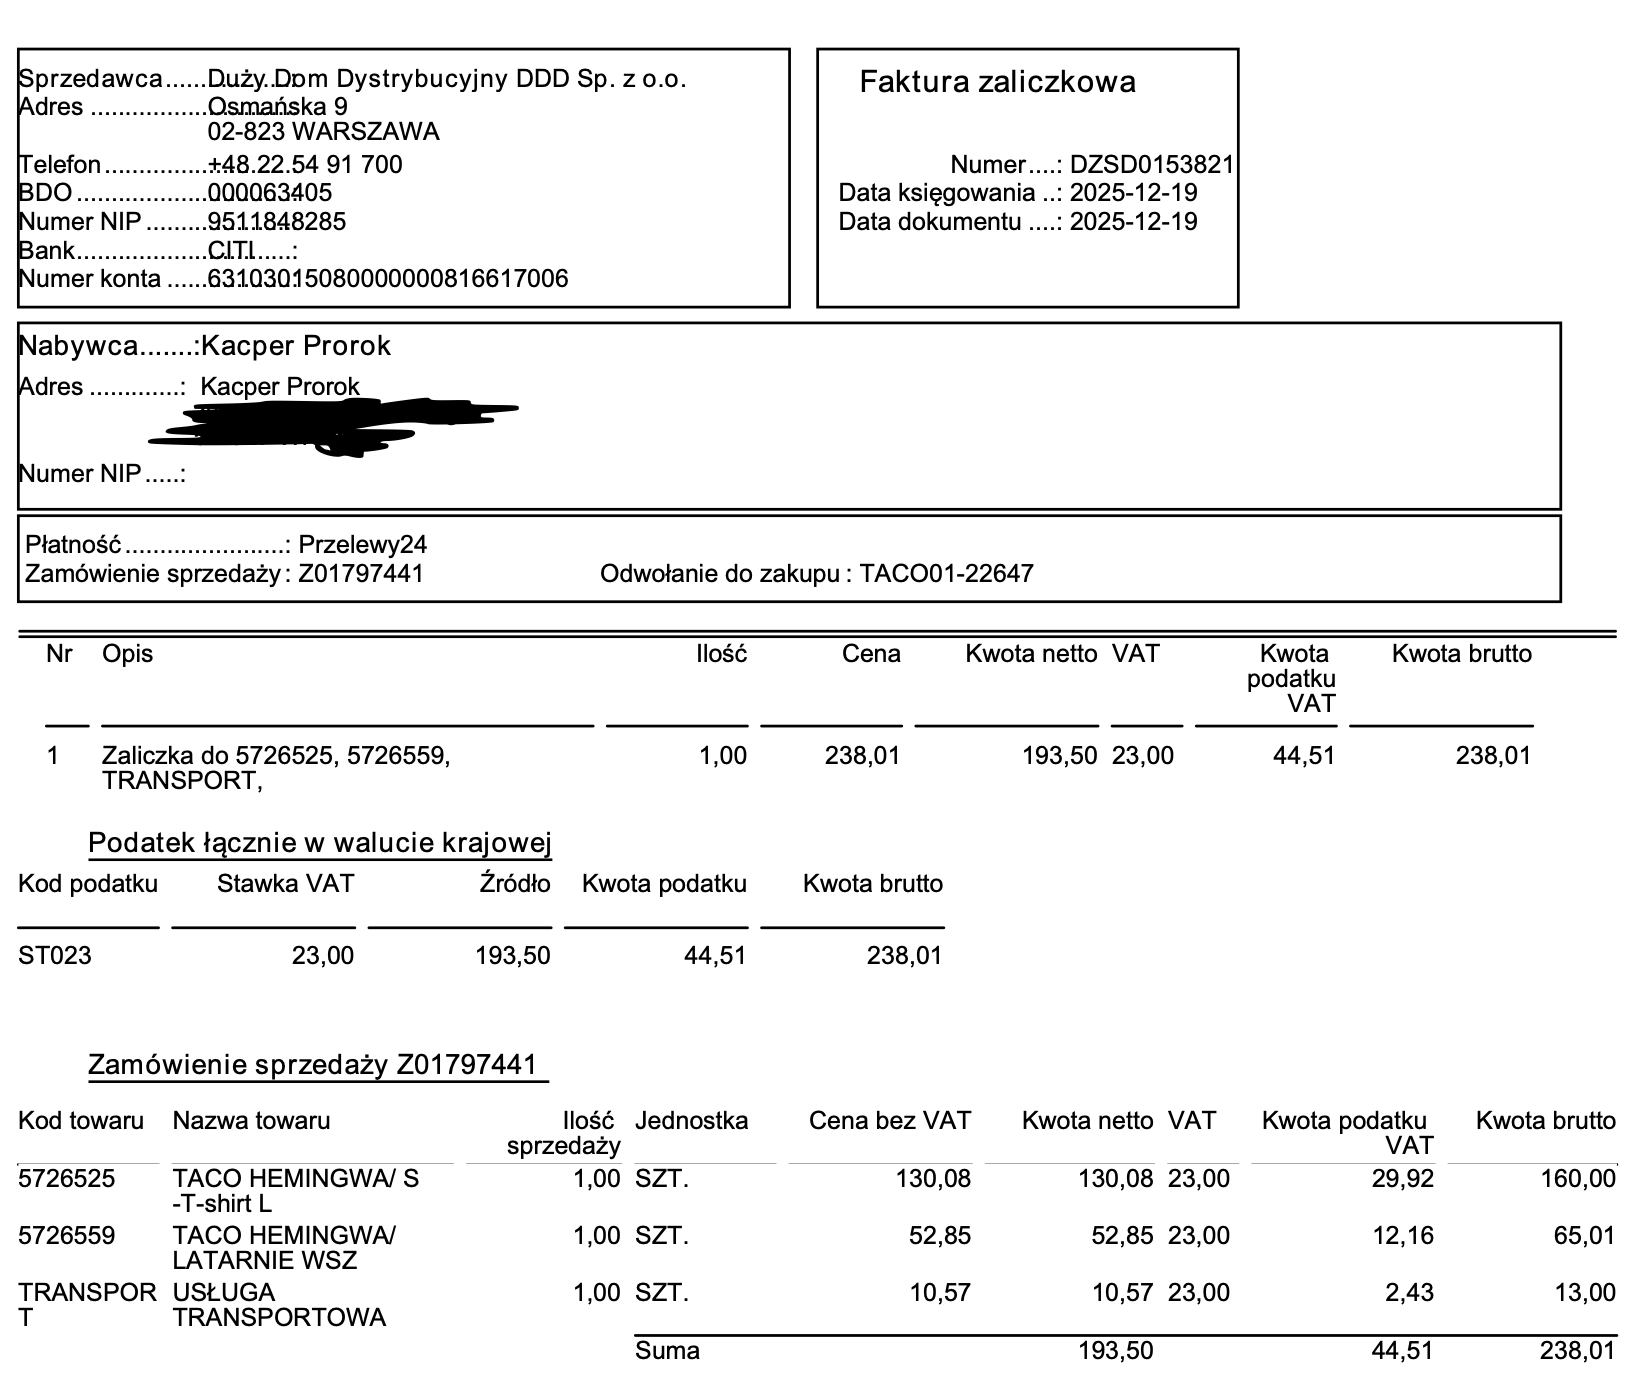

In [22]:
from PIL import Image
from IPython.display import display

# Ścieżka do Twojego pliku PNG
image_path = "data/invoices/DZSD_jpg.png"

try:
    # Otwieramy obraz bezpośrednio
    img = Image.open(image_path)
    
    # Wyświetlamy go w notatniku
    print(f"Otwarto obraz: {image_path}")
    display(img)
    
except Exception as e:
    print(f"Błąd: {e}")

In [23]:
results = []
print("Testowanie Docling...")
start = time.perf_counter()
text_docling = ""
t_docling = None
score_docling = None
docling_dfs = []
tables_all = []
metadata_found = {}

try:
    converter = DocumentConverter()
    res = converter.convert("data/invoices/DZSD_jpg.png")
    try:
        md = res.document.export_to_markdown()
    except Exception:
        md = ""
        for page in res.document.pages:
            txt = page.export_to_markdown()
            if txt:
                md += txt + "\n"
    text_docling = md
    for table in res.document.tables:
        df = table.export_to_dataframe()
        docling_dfs.append(df)
    t_docling = time.perf_counter() - start
    if text_docling:
        metadata_found = extract_metadata_regex(text_docling)
    
except Exception as e:
    print(f"Docling Error: {e}")
    t_docling = time.perf_counter() - start
    

print(f"time:{t_docling}")
print("\n")
for i, df in enumerate(docling_dfs):
    print(f"\n--- Tabela #{i+1} (Docling) ---")
    display(df)

print("\n🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):")
for k, v in metadata_found.items():
    if v:
        print(f"✅ {k}: {v}")
    else:
        print(f"⚠️ {k}: Nie znaleziono (wymagany lepszy Regex)")

Testowanie Docling...


Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


time:7.188218167008017



--- Tabela #1 (Docling) ---


\
0                                   1   
1  Podatek łacznie w walucie krajowej   
2                         Kod podatku   
3                               ST023   

                                    Nr Opis  \
0  Zaliczka do 5726525, 5726559, TRANSPORT,   
1        Podatek łacznie w walucie krajowej   
2                               Kod podatku   
3                                     ST023   

                                                            Ilość  \
0  Zaliczka do 5726525, 5726559, TRANSPORT,                  1,00   
1        Podatek łacznie w walucie krajowej                         
2                                Stawka VAT  Źródło Kwota podatku   
3                                     23,00          193,50 44,51   

           Cena Kwota netto VAT Kwota podatku VAT Kwota brutto  
0        238,01    193,50 23,00             44,51       238,01  
1                                                               
2  Kwota brutto                                                 
3        238,01


--- Tabela #2 (Docling) ---


Kod towaru                  Nazwa towaru llość Jednostka sprzedaży  \
0    5726525   TACO HEMINGWA/ S -T-shirt L                 1,00 SZT.   
1    5726559   TACO HEMINGWA/ LATARNIE WSZ                 1,00 SZT.   
2             TRANSPOR USANSP TRANSPORTOWA                 1,00 SZT.   
3                                                               Suma   

  Cena bez VAT Kwota netto VAT Kwota podatku VAT Kwota brutto  
0       130,08    130,08 23,00             29,92       160,00  
1        52,85     52,85 23,00             12,16        65,01  
2        10,57     10,57 23,00              2,43        13,00  
3                       193,50             44,51       238,01


🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):
✅ Numer faktury: zaliczkowa
✅ Data wystawienia: 2025-12-19
⚠️ Suma (Brutto): Nie znaleziono (wymagany lepszy Regex)


## 3.4 Azure Document Inteligence

### 3.4.1 Faktura prosta

In [24]:
def azure_table_to_dataframe(table_result):
    """Pomocnicza funkcja do konwersji tabeli Azure na DataFrame"""
    row_count = table_result.row_count
    col_count = table_result.column_count
    grid = [["" for _ in range(col_count)] for _ in range(row_count)]
    
    for cell in table_result.cells:
        grid[cell.row_index][cell.column_index] = cell.content
        
    if row_count > 1:
        return pd.DataFrame(grid[1:], columns=grid[0])
    else:
        return pd.DataFrame(grid)

def analyze_invoice(pdf_path):
    print(f"--- 🧾 Analiza Faktury: {os.path.basename(pdf_path)} ---")
    
    try:
        client = DocumentIntelligenceClient(
            endpoint=AZURE_ENDPOINT, 
            credential=AzureKeyCredential(AZURE_KEY)
        )

        with open(pdf_path, "rb") as f:
            poller = client.begin_analyze_document(
                "prebuilt-invoice",  
                body=f,
                content_type="application/pdf"
            )
        
        result = poller.result()
        if result.documents:
            doc = result.documents[0] 
            fields = doc.fields
            
            print("\n🔍 GŁÓWNE DANE FAKTURY:")
            vendor = fields.get("VendorName")
            customer = fields.get("CustomerName")
            invoice_date = fields.get("InvoiceDate")
            invoice_id = fields.get("InvoiceId")
            total = fields.get("InvoiceTotal")
            
            if vendor: print(f"🏢 Sprzedawca: {vendor.get('content')}")
            if customer: print(f"👤 Klient:     {customer.get('content')}")
            if invoice_id: print(f"🔢 Nr faktury: {invoice_id.get('content')}")
            if invoice_date: print(f"📅 Data:       {invoice_date.get('content')}")
            
            if total:
                val = total.get('valueCurrency')
                amount = val.get('amount') if val else total.get('content')
                currency = val.get('currencySymbol') if val else ""
                print(f"💰 SUMA:       {amount} {currency}")

        if result.tables:
            print(f"\n📦 POZYCJE NA FAKTURZE ({len(result.tables)} tabel):")
            for i, table in enumerate(result.tables):
                df = azure_table_to_dataframe(table)
                try:
                    display(df)
                except NameError:
                    print(df)
        else:
            print("ℹ️ Nie wykryto tabeli z produktami.")

    except Exception as e:
        print(f"❌ Błąd Azure: {e}")

plik_testowy = "data/invoices/invoice-1-3.pdf"

if os.path.exists(plik_testowy):
    analyze_invoice(plik_testowy)
else:
    print(f"⚠️ Nie znaleziono pliku: {plik_testowy}")

--- 🧾 Analiza Faktury: invoice-1-3.pdf ---

🔍 GŁÓWNE DANE FAKTURY:
🏢 Sprzedawca: zencorporations
👤 Klient:     La Galerie
🔢 Nr faktury: 1213
📅 Data:       16.12.2021
💰 SUMA:       2809.3 None

📦 POZYCJE NA FAKTURZE (3 tabel):


Product Unit Price [EUR] Total [EUR]
0         Glossostigma\nQty. 3             9.90       29.70
1           Bayberry\nQty. 222             5.44    1,207.68
2           Waxflower\nQty. 34             1.67       56.78
3   Carolina Geranium\nQty. 45             4.17      187.65
4             Smooth Solomon's                             
5                         Seal                             
6                       Qty. 3             4.97       14.91
7  El Yunque Colorado\nQty. 23             9.97      229.31

Queen Anne's Lace              
0                      Qty. 32  6.05  193.60
1  Alaskan Douglasia\nQty. 122  4.36  531.92
2          Deer Sedge\nQty. 23  3.82   87.86
3       Indian Tobacco\nQty. 2  7.25   14.50

Subtotal  2553.91
0  Sales Tax   255.39
1  Total Due  2809.30

### 3.4.2 Faktura cięzka

In [25]:
def azure_table_to_dataframe(table_result):
    """Pomocnicza funkcja do konwersji tabeli Azure na DataFrame"""
    row_count = table_result.row_count
    col_count = table_result.column_count
    grid = [["" for _ in range(col_count)] for _ in range(row_count)]
    
    for cell in table_result.cells:
        grid[cell.row_index][cell.column_index] = cell.content
        
    if row_count > 1:
        return pd.DataFrame(grid[1:], columns=grid[0])
    else:
        return pd.DataFrame(grid)

def analyze_invoice(pdf_path):
    print(f"--- 🧾 Analiza Faktury: {os.path.basename(pdf_path)} ---")
    
    try:
        client = DocumentIntelligenceClient(
            endpoint=AZURE_ENDPOINT, 
            credential=AzureKeyCredential(AZURE_KEY)
        )

        with open(pdf_path, "rb") as f:
            poller = client.begin_analyze_document(
                "prebuilt-invoice",  
                body=f,
                content_type="application/pdf"
            )
        
        result = poller.result()
        if result.documents:
            doc = result.documents[0] 
            fields = doc.fields
            
            print("\n🔍 GŁÓWNE DANE FAKTURY:")
            vendor = fields.get("VendorName")
            customer = fields.get("CustomerName")
            invoice_date = fields.get("InvoiceDate")
            invoice_id = fields.get("InvoiceId")
            total = fields.get("InvoiceTotal")
            
            if vendor: print(f"🏢 Sprzedawca: {vendor.get('content')}")
            if customer: print(f"👤 Klient:     {customer.get('content')}")
            if invoice_id: print(f"🔢 Nr faktury: {invoice_id.get('content')}")
            if invoice_date: print(f"📅 Data:       {invoice_date.get('content')}")
            
            if total:
                val = total.get('valueCurrency')
                amount = val.get('amount') if val else total.get('content')
                currency = val.get('currencySymbol') if val else ""
                print(f"💰 SUMA:       {amount} {currency}")

        if result.tables:
            print(f"\n📦 POZYCJE NA FAKTURZE ({len(result.tables)} tabel):")
            for i, table in enumerate(result.tables):
                df = azure_table_to_dataframe(table)
                try:
                    display(df)
                except NameError:
                    print(df)
        else:
            print("ℹ️ Nie wykryto tabeli z produktami.")

    except Exception as e:
        print(f"❌ Błąd Azure: {e}")

plik_testowy = "data/invoices/invoice-3-0.pdf"

if os.path.exists(plik_testowy):
    analyze_invoice(plik_testowy)
else:
    print(f"⚠️ Nie znaleziono pliku: {plik_testowy}")

--- 🧾 Analiza Faktury: invoice-3-0.pdf ---

🔍 GŁÓWNE DANE FAKTURY:
🏢 Sprzedawca: €
NEID
👤 Klient:     Obacht AG
🔢 Nr faktury: 4235
📅 Data:       October 12, 2021
💰 SUMA:       213470.0 None

📦 POZYCJE NA FAKTURZE (2 tabel):


Make/Model Product Code Unit Price
0  Chrysler/300M\nCountry of origin: France\nColo...  762-88-0358      45400
1  Mercedes-Benz/SL-Class\nCountry of origin: Ita...  630-35-4784      12100
2    Audi/90\nCountry of origin: Spain\nColor: Black  582-33-2563      18100
3  Ford/Bronco\nCountry of origin: Spain\nColor: ...  877-84-8130      30900
4     Audi/A6\nCountry of origin: France\nColor: Red  638-13-7553      30800
5  Mitsubishi/Eclipse\nCountry of origin: Spain\n...  771-81-4708      22900
6  Hummer/H1\nCountry of origin: Germany\nColor: ...  694-41-6257      27500

Subtotal  187700
0                        Sales Tax   18770
1              Shipping & Handling    7000
2  Total Due By: November 12, 2021  213470

### 3.4.3 Faktura cięzka + OCR

Ta sama co Docling

In [26]:
def azure_table_to_dataframe(table_result):
    """Pomocnicza funkcja do konwersji tabeli Azure na DataFrame"""
    row_count = table_result.row_count
    col_count = table_result.column_count
    grid = [["" for _ in range(col_count)] for _ in range(row_count)]
    
    for cell in table_result.cells:
        grid[cell.row_index][cell.column_index] = cell.content
        
    if row_count > 1:
        return pd.DataFrame(grid[1:], columns=grid[0])
    else:
        return pd.DataFrame(grid)

def analyze_invoice(pdf_path):
    print(f"--- 🧾 Analiza Faktury: {os.path.basename(pdf_path)} ---")
    
    try:
        client = DocumentIntelligenceClient(
            endpoint=AZURE_ENDPOINT, 
            credential=AzureKeyCredential(AZURE_KEY)
        )

        with open(pdf_path, "rb") as f:
            poller = client.begin_analyze_document(
                "prebuilt-invoice",  
                body=f,
                content_type="image/png"
            )
        
        result = poller.result()
        if result.documents:
            doc = result.documents[0] 
            fields = doc.fields
            
            print("\n🔍 GŁÓWNE DANE FAKTURY:")
            vendor = fields.get("VendorName")
            customer = fields.get("CustomerName")
            invoice_date = fields.get("InvoiceDate")
            invoice_id = fields.get("InvoiceId")
            total = fields.get("InvoiceTotal")
            
            if vendor: print(f"🏢 Sprzedawca: {vendor.get('content')}")
            if customer: print(f"👤 Klient:     {customer.get('content')}")
            if invoice_id: print(f"🔢 Nr faktury: {invoice_id.get('content')}")
            if invoice_date: print(f"📅 Data:       {invoice_date.get('content')}")
            
            if total:
                val = total.get('valueCurrency')
                amount = val.get('amount') if val else total.get('content')
                currency = val.get('currencySymbol') if val else ""
                print(f"💰 SUMA:       {amount} {currency}")

        if result.tables:
            print(f"\n📦 POZYCJE NA FAKTURZE ({len(result.tables)} tabel):")
            for i, table in enumerate(result.tables):
                df = azure_table_to_dataframe(table)
                try:
                    display(df)
                except NameError:
                    print(df)
        else:
            print("ℹ️ Nie wykryto tabeli z produktami.")

    except Exception as e:
        print(f"❌ Błąd Azure: {e}")

plik_testowy = "data/invoices/DZSD_jpg.png"

if os.path.exists(plik_testowy):
    analyze_invoice(plik_testowy)
else:
    print(f"⚠️ Nie znaleziono pliku: {plik_testowy}")

--- 🧾 Analiza Faktury: DZSD_jpg.png ---

🔍 GŁÓWNE DANE FAKTURY:
🏢 Sprzedawca: Duży .. Dom Dystrybucyjny DDD Sp. z o.o.
👤 Klient:     :Kacper Prorok
🔢 Nr faktury: DZSD0153821
📅 Data:       2025-12-19
2025-12-19
💰 SUMA:       238.01 None

📦 POZYCJE NA FAKTURZE (4 tabel):


Sprzedawca Duży .. Dom Dystrybucyjny DDD Sp. z o.o.
0        Adres                               Osmańska 9
1                                       02-823 WARSZAWA
2      Telefon                         +48.22.54 91 700
3          BDO                                000063405
4    Numer NIP                               9511848285
5         Bank                           C.I.T.L .....:
6  Numer konta               63103015080000000816617006

Nr                                       Opis Ilość    Cena Kwota netto  \
0  1  Zaliczka do 5726525, 5726559,\nTRANSPORT,  1,00  238,01      193,50   

     VAT Kwota\npodatku\nVAT Kwota brutto  
0  23,00               44,51       238,01

Kod podatku Stawka VAT  Źródło Kwota podatku Kwota brutto
0       ST023      23,00  193,50         44,51       238,01

Kod towaru                  Nazwa towaru Ilość\nsprzedaży Jednostka  \
0      5726525  TACO HEMINGWA/ S\n-T-shirt L             1,00      SZT.   
1      5726559  TACO HEMINGWA/\nLATARNIE WSZ             1,00      SZT.   
2  TRANSPOR\nT          USŁUGA\nTRANSPORTOWA             1,00      SZT.   

  Cena bez VAT Kwota netto    VAT Kwota podatku\nVAT Kwota brutto  
0       130,08      130,08  23,00              29,92       160,00  
1        52,85       52,85  23,00              12,16        65,01  
2        10,57       10,57  23,00               2,43        13,00

# Rozdział 4: OCR i skany

Z racji, ze funkcja OCR występuje tylko w przypadku bibliotek test w tym miejscu mozna by przeprowadzic tylko dla Docling i Azure Document Inteligence. Lecz postaram się tutaj jeszcze pokazać jedną bibliotekę, która słuzy stricte do tylko nakladania OCR na pdf - Tesseract. Z jej pomoca mozemy najpierw nalozyc tekst na pdf/jpg a potem uzyc bibliotek do wyciagania tekstu - PyMuPDF i PDFplumber

## 4.1 Tesseract + PyMuPDF

### 4.1.2 Ulotka 1

Otwarto obraz: data/images/Screenshot 2026-02-01 at 09.58.02.png


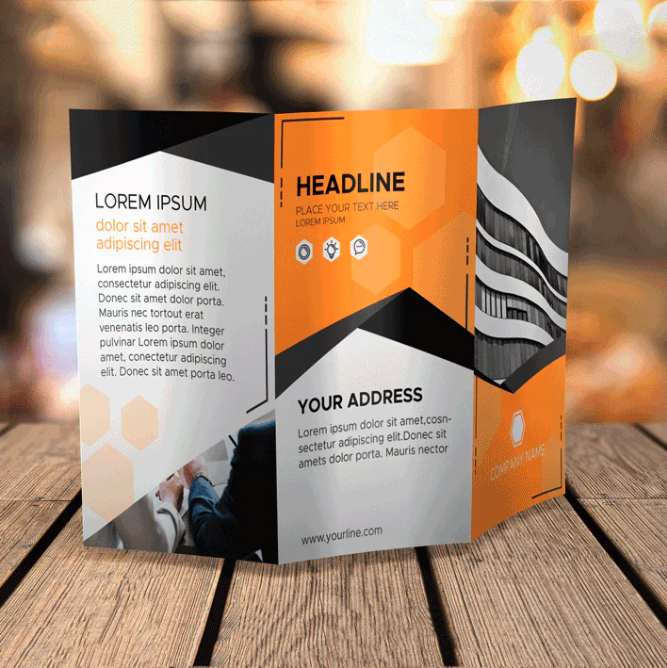

In [ ]:
from PIL import Image
from IPython.display import display

# Ścieżka do Twojego pliku PNG
image_path = "data/images/Screenshot 2026-02-01 at 09.58.02.png"

try:
    # Otwieramy obraz bezpośrednio
    img = Image.open(image_path)
    
    
    # Wyświetlamy go w notatniku
    print(f"Otwarto obraz: {image_path}")
    display(img)
    
except Exception as e:
    print(f"Błąd: {e}")

In [ ]:
import pytesseract
image = Image.open("data/images/Screenshot 2026-02-01 at 09.58.02.png")

width, height = img.size
new_size = (width * 3, height * 3)
img_resized = img.resize(new_size, Image.Resampling.LANCZOS) ## powiekszenie obrazu co ulatwi prace

pdf_bytes = pytesseract.image_to_pdf_or_hocr(img_resized, extension='pdf', lang='eng')

with open("data/images/ulotkaPDF.pdf", "wb") as f:
            f.write(pdf_bytes)

results = []
print("Testowanie PyMuPDF (Best Effort)...")
start = time.perf_counter()

try:
    doc = fitz.open("data/images/ulotkaPDF.pdf")
    text_parts = []
    
    for page in doc:
        blocks = page.get_text("blocks", sort=True)
        
        page_height = page.rect.height
        
        for b in blocks:
            x0, y0, x1, y1, text, block_no, block_type = b

            if block_type != 0:
                continue
                
            if y0 < page_height * 0.05 or y1 > page_height * 0.95:
                continue
            
            if len(text.strip()) < 3 and text.strip().isdigit():
                continue
                
            text_parts.append(text)

    raw_text = "\n".join(text_parts)
    
    text_pymu_cleaned = clean_pymupdf_text(raw_text)
    
    t_pymu = time.perf_counter() - start
    
    ground_truth_cleaned = " ".join(ground_truth_simple_2.split())
    score_pymu = fuzz.ratio(text_pymu_cleaned, ground_truth_cleaned)

except Exception as e:
    print(f"PyMuPDF Error: {e}")
    text_pymu_cleaned = ""
    t_pymu = 0
    score_pymu = 0

print(f"Time: {t_pymu:.4f} s")
print(f"Accuracy Score: {score_pymu:.2f}%")

print("-" * 30)
print("PREVIEW (First 500 chars):")
print(text_pymu_cleaned[:1500] + "...") 
print("-" * 30)



Testowanie PyMuPDF (Best Effort)...
Time: 0.0775 s
Accuracy Score: 7.64%
------------------------------
PREVIEW (First 500 chars):
LOREM IPSUM rem ipsum dolor sit amet, nsectetur adipiscing elit Donec sit amet dolor porta Mauris nec tortout erat venenatis leo porta Integer pulvinar Lorem ipsum dolor amet, conectetur edipiscing elit. Donec sit amet porta leo. sum doror sit onan ih dipiscing elit. Donec St wi ne _ Mauris nector ; ‘* f amets porta...
------------------------------


## 4.2 Pytesreact + PDFplumber

### 4.2.1 Ulotka prosta

## 4.3 Docling

### 4.3.1 Ulotka prosta

In [62]:
from docling.document_converter import DocumentConverter

# Ścieżka do pliku
plik = "data/images/Screenshot 2026-02-01 at 09.58.10.png"

print(f"--- 🚀 Docling: {plik} ---")

try:
    # 1. Inicjalizacja i konwersja
    converter = DocumentConverter()
    result = converter.convert(plik)

    # 2. Wyświetlenie całej zawartości
    # Docling najlepiej zwraca treść jako Markdown (zachowuje strukturę nagłówków i tabel)
    text = result.document.export_to_markdown()
    
    print(text)

except Exception as e:
    print(f"❌ Błąd Docling: {e}")

[2026-02-01 10:42:09,846] [    INFO] document.py:538 - detected formats: [<InputFormat.IMAGE: 'image'>]
[2026-02-01 10:42:09,899] [    INFO] document_converter.py:449 - Going to convert document batch...
[2026-02-01 10:42:09,907] [    INFO] document_converter.py:494 - Initializing pipeline for StandardPdfPipeline with options hash 41faac6ec297655a20396e364a95b08b
[2026-02-01 10:42:09,922] [    INFO] auto_ocr_model.py:56 - Auto OCR model selected ocrmac.
[2026-02-01 10:42:09,932] [    INFO] accelerator_utils.py:96 - Accelerator device: 'mps'


--- 🚀 Docling: data/images/Screenshot 2026-02-01 at 09.58.10.png ---


[2026-02-01 10:42:23,209] [    INFO] accelerator_utils.py:96 - Accelerator device: 'mps'
[2026-02-01 10:42:24,538] [    INFO] base_pipeline.py:65 - Processing document Screenshot 2026-02-01 at 09.58.10.png
[2026-02-01 10:42:47,072] [    INFO] document_converter.py:473 - Finished converting document Screenshot 2026-02-01 at 09.58.10.png in 37.26 sec.


<!-- image -->


## 4.4 Azure Document Inteligence

### 4.4.1 Ulotka 1

In [54]:
import os
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.core.credentials import AzureKeyCredential

# ==========================================
# 🔑 KONFIGURACJA
# ==========================================
AZURE_ENDPOINT 
AZURE_KEY 

def simple_ocr_azure(image_path):
    print(f"--- 📄 Odczyt tekstu (Azure): {os.path.basename(image_path)} ---")
    
    try:
        # 1. Klient
        client = DocumentIntelligenceClient(
            endpoint=AZURE_ENDPOINT, 
            credential=AzureKeyCredential(AZURE_KEY)
        )

        # 2. Wysyłamy plik - używamy modelu "prebuilt-read" (najlepszy do samego tekstu)
        with open(image_path, "rb") as f:
            poller = client.begin_analyze_document(
                "prebuilt-read",  # 👈 ZMIANA: Model do czytania, a nie do faktur
                body=f,
                content_type="image/png"
            )
        
        # 3. Czekamy na wynik
        result = poller.result()
        
        # 4. Wyświetlamy tekst linia po linii
        # Azure dzieli wynik na strony -> linie -> słowa
        if result.pages:
            print("\n📝 ZNALEZIONA TREŚĆ:")
            print("=" * 30)
            
            for page in result.pages:
                for line in page.lines:
                    print(line.content)
                    
            print("=" * 30)
        else:
            print("ℹ️ Nie znaleziono tekstu.")

    except Exception as e:
        print(f"❌ Błąd Azure: {e}")

# ==========================================
# 🚀 TESTOWANIE
# ==========================================
plik_testowy = "data/images/Screenshot 2026-02-01 at 09.58.21.png"

if os.path.exists(plik_testowy):
    simple_ocr_azure(plik_testowy)
else:
    print(f"⚠️ Nie znaleziono pliku: {plik_testowy}")

[2026-02-01 10:28:57,453] [    INFO] _universal.py:508 - Request URL: 'https://documentationiwb.cognitiveservices.azure.com//documentintelligence/documentModels/prebuilt-read:analyze?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'content-type': 'application/octet-stream'
    'Accept': 'application/json'
    'x-ms-client-request-id': '6f12e5f6-ff50-11f0-a28a-76f2d0160f28'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.2 Python/3.12.0 (macOS-26.2-arm64-arm-64bit)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
A body is sent with the request


--- 📄 Odczyt tekstu (Azure): Screenshot 2026-02-01 at 09.58.21.png ---


[2026-02-01 10:28:59,169] [    INFO] _universal.py:554 - Response status: 202
Response headers:
    'Content-Length': '0'
    'Operation-Location': 'REDACTED'
    'x-envoy-upstream-service-time': 'REDACTED'
    'apim-request-id': 'REDACTED'
    'Strict-Transport-Security': 'REDACTED'
    'x-content-type-options': 'REDACTED'
    'x-ms-region': 'REDACTED'
    'Date': 'Sun, 01 Feb 2026 09:28:58 GMT'
[2026-02-01 10:28:59,189] [    INFO] _universal.py:511 - Request URL: 'https://documentationiwb.cognitiveservices.azure.com/documentintelligence/documentModels/prebuilt-read/analyzeResults/9f5b8d44-e93e-4c9e-95e6-59c1d15ed49d?api-version=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-client-request-id': '6f12e5f6-ff50-11f0-a28a-76f2d0160f28'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.2 Python/3.12.0 (macOS-26.2-arm64-arm-64bit)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
No body was attached to the request
[2026-02-01 10:28:59,365] [    INFO] _universal.py:554 - R


📝 ZNALEZIONA TREŚĆ:
LOGO
TWOJA FIRMA
WYSOKA JAKOŚĆ USŁUG
LO
TV
WYS
%
Lorem ipsum dolor sit amet.
consectetur adipiscing elit.
Mauris semper ligula sit amet
hendrerit iaculis. Nunc commodo
TWOJA FIRMA
· ipsum dolor sit amet.
'ur adipiscing elit.
er ligula sit amet
: Nunc commodo
la.pl
Wysoka jakość
Precyzja działania
Niezawodność
www.twojastrona.pl
SPRAWDŹ NASZĄ OFERTĘ
WYSOKA JAKOŚĆ USŁUG
Lorem ipsum dolor sit amet, consectetur adipiscing elit.
Mauris semper ligula sit amet hendrerit laculis. Nunc
commodo tellus et neque posuere molestie quis ut
lectus. Suspendisse placerat vitae urna eget maximus,
Donec vitae rhoncus erat. Nulla euismod diam vel
convallis maximus.
TWOJA FIRMA
14%
Lorem ipsum dolor sit amet,
consectetur adipiscing elit.
Mauris semper ligula sit amet
hendrerit laculis. Nunc commodo
TWOJA FIRMA
